<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemics 101</h1>
<h1>Or why your exponential fits of CoVID numbers are wrong</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.integrate
import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

scipy     1.4.1
autopep8  1.5
pandas    1.0.1
watermark 2.0.2
json      2.0.9
networkx  2.4
numpy     1.18.1
Tue Mar 24 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 4de15fae75b766c4ddbeaef47e88ba6dd06cb0ce


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## EpiModel Class

We start by implementing a simple convenience function to help us explore the various models without having too much Python code in the way

In [36]:
class EpiModel:
    """Simple Epidemic Model Implementation
    
        Provides a way to implement and numerically integrate 
    """
    def __init__(self, compartments=None):
        self.transitions = nx.DiGraph()
        
        if compartments is not None:
            self.transitions.add_nodes_from([comp for comp in compartments])
    
    def add_interaction(self, source, target, agent, rate):        
        self.transitions.add_edge(source, target, agent=agent, rate=rate)        
        
    def add_spontaneous(self, source, target, rate):
        self.transitions.add_edge(source, target, rate=rate)
        
    def _new_cases(self, population, time, pos):
        """Internal function used by integration routine"""
        diff = np.zeros(len(pos))
        N = np.sum(population)        
        
        for edge in self.transitions.edges(data=True):
            source = edge[0]
            target = edge[1]
            trans = edge[2]
            
            rate = trans['rate']*population[pos[source]]
            
            if 'agent' in trans:
                agent = trans['agent']
                rate *= population[pos[agent]]/N
                
            diff[pos[source]] -= rate
            diff[pos[target]] += rate
            
        return diff
    
    def plot(self, title=None, normed=False):
        """Convenience function for plotting"""
        try:
            if normed:
                N = self.values_.iloc[0].sum()
                ax = (self.values_/N).plot()
            else:
                ax = self.values_.plot()
                
            ax.set_xlabel('Time')
            ax.set_ylabel('Population')
            
            if title is not None:
                ax.set_title(title)
            
            return ax
        except:
            raise NotInitialized('You must call integrate() first')
    
    def __getattr__(self, name):
        """Dynamic method to return the individual compartment values"""
        if 'values_' in self.__dict__:
            return self.values_[name]
        else:
            raise AttributeError("'EpiModel' object has no attribute '%s'" % name)
    
    def integrate(self, timesteps, **kwargs):
        """Numerically integrate the epidemic model"""
        pos = {comp: i for i, comp in enumerate(kwargs)}
        population=np.zeros(len(pos))
        
        for comp in pos:
            population[pos[comp]] = kwargs[comp]
        
        time = np.arange(1, timesteps, 1)

        self.values_ = pd.DataFrame(scipy.integrate.odeint(self._new_cases, population, time, args=(pos,)), columns=pos.keys(), index=time)
        
    def __repr__(self):
        text = 'Epidemic Model with %u compartments and %u transitions:\n\n' % \
              (self.transitions.number_of_nodes(), 
               self.transitions.number_of_edges())
        
        for edge in self.transitions.edges(data=True):
            source = edge[0]
            target = edge[1]
            trans = edge[2]
            
            rate = trans['rate']

            if 'agent' in trans:
                agent = trans['agent']
                text += "%s + %s = %s %f\n" % (source, agent, target, rate)
            else:
                text+="%s -> %s %f\n" % (source, target, rate)
                
        return text

## SI Model

The first model we will look at is called the SI model and it only consists of two compartments (susceptible and infectious) and one transion between them

In [5]:
beta = 0.2
SI = EpiModel()
SI.add_interaction('S', 'I', 'I', beta)

print(SI)

Epidemic Model with 2 compartments and 1 transitions:

S + I = I 0.200000



In other words, when a susceptiblem person encounters an infectious person, s/he aquires the infection with probability 0.2. We can integrate it easily. If in our initial population of 100,000 individuals we have 10 who are infected at time zero

In [6]:
N = 100000
I0 = 10

SI.integrate(100, S=N-I0, I=I0)

And to plot it:

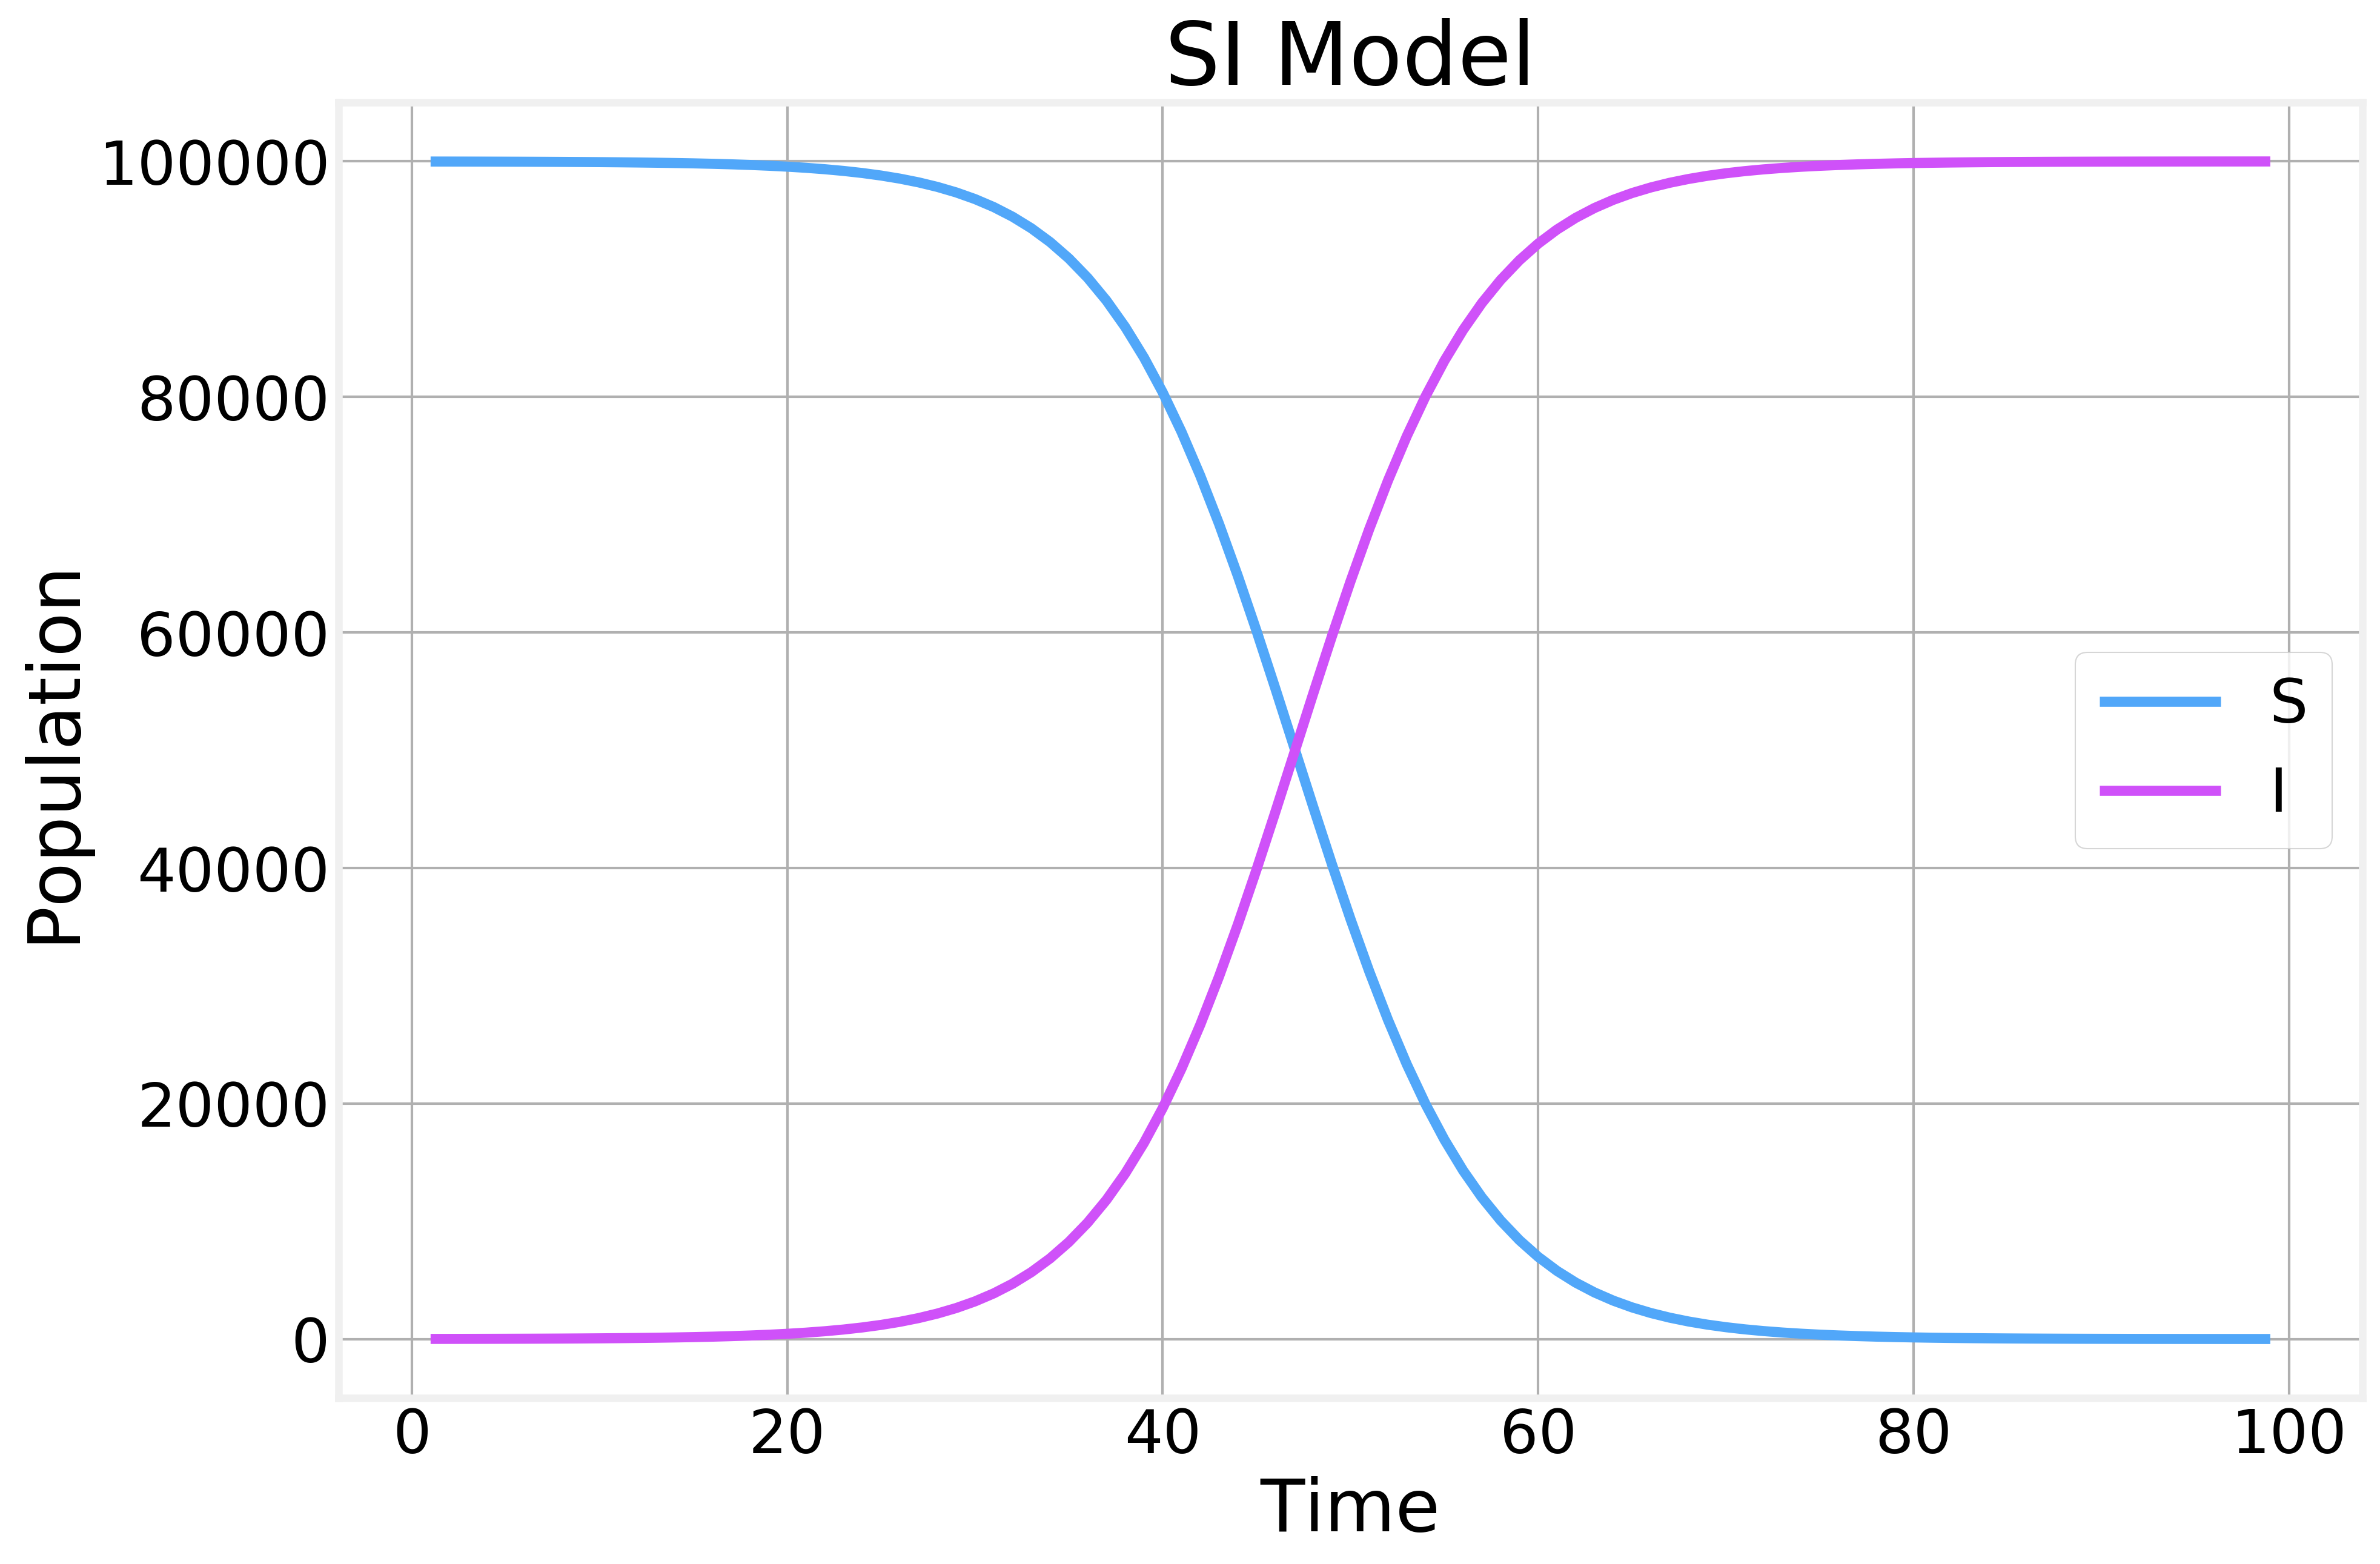

In [7]:
SI.plot('SI Model')

This isn't very interesting: after a few steps everyone is infected!

## SIR Model

A more interesting and realistic model is the SIR model. It allows people to recover from the infection after some time, so now we have 3 compartments and 2 transitions

In [8]:
beta = 0.2
mu = 0.1

SIR = EpiModel()
SIR.add_interaction('S', 'I', 'I', beta)
SIR.add_spontaneous('I', 'R', mu)

In [9]:
print(SIR)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.200000
I -> R 0.100000



And the dynamics is more interesting as well:

In [10]:
SIR.integrate(365, S=N-I0, I=I0, R=0)

And a quick visualization

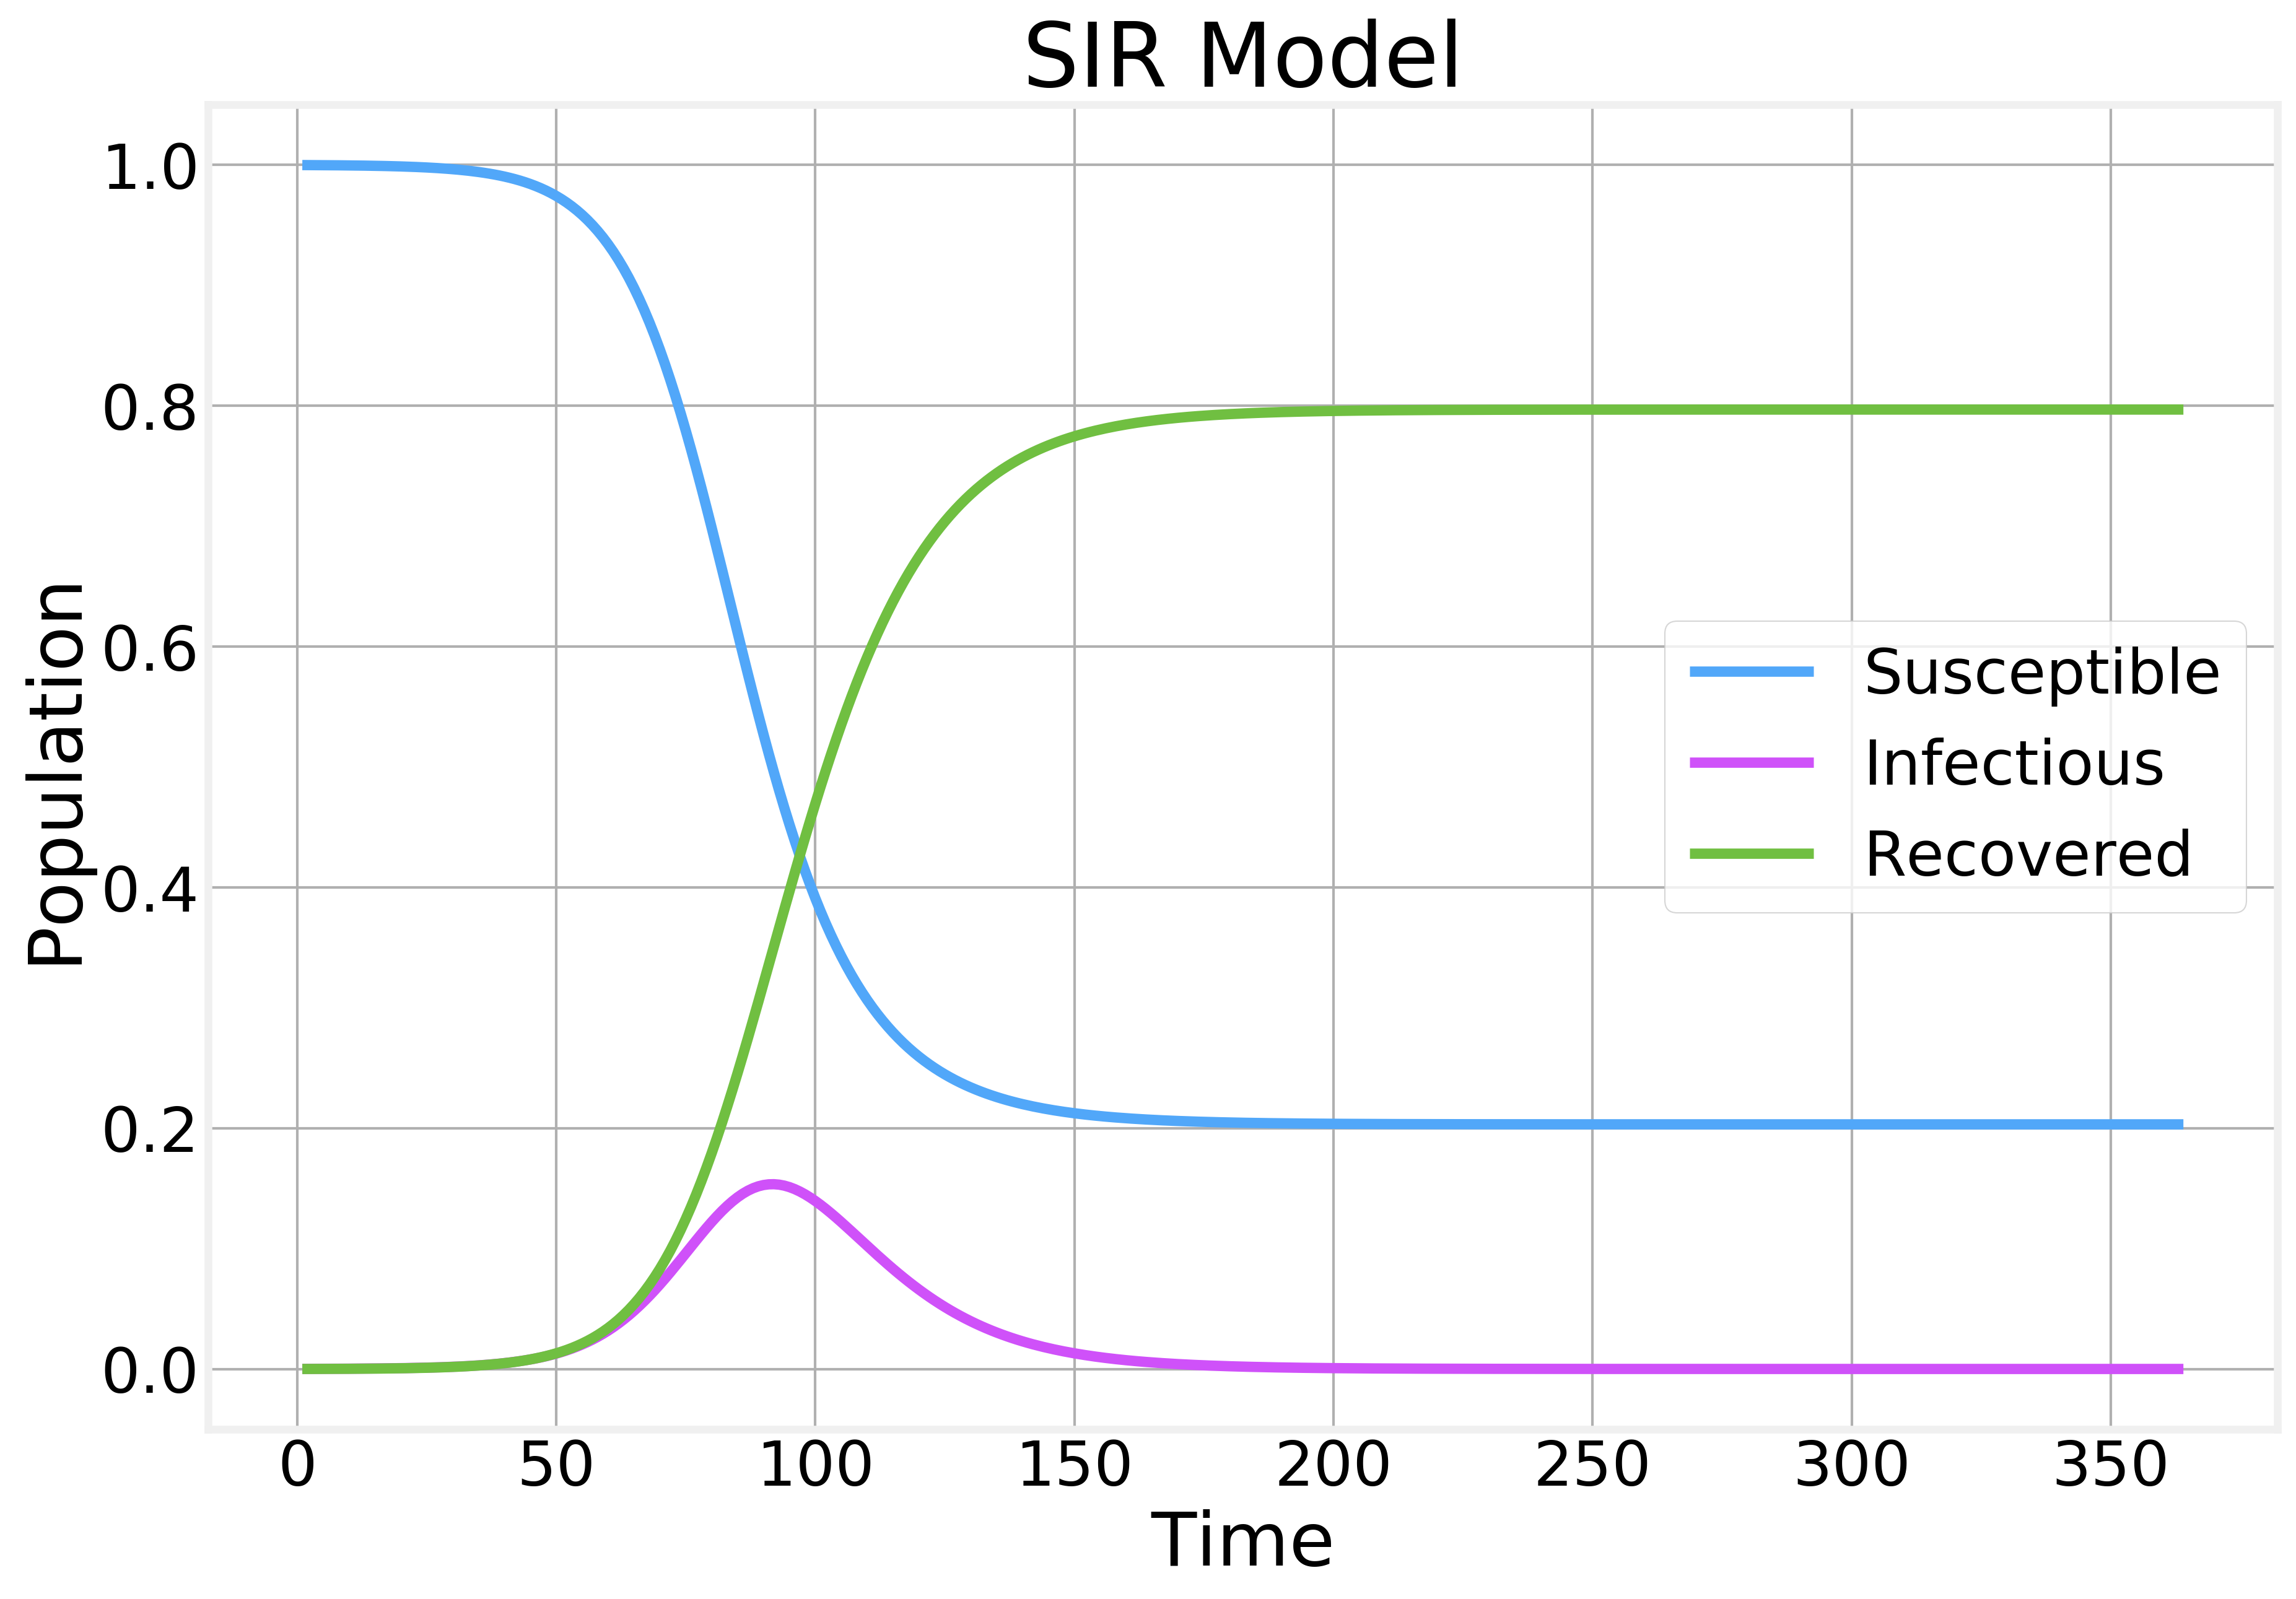

In [11]:
ax = SIR.plot('SIR Model', normed=True)
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

The purple line is the number of currently infectious cases as a function of time. As we can see, not all of the population is infectious at the same time, and, in fact, only about $80\%$ of the population is ever infected, as shown by the green curve representing the fraction of recovered.

The typical bell curve you're likely to see (as asked to flatten) is simply the number of infectious individuals as a function of time:

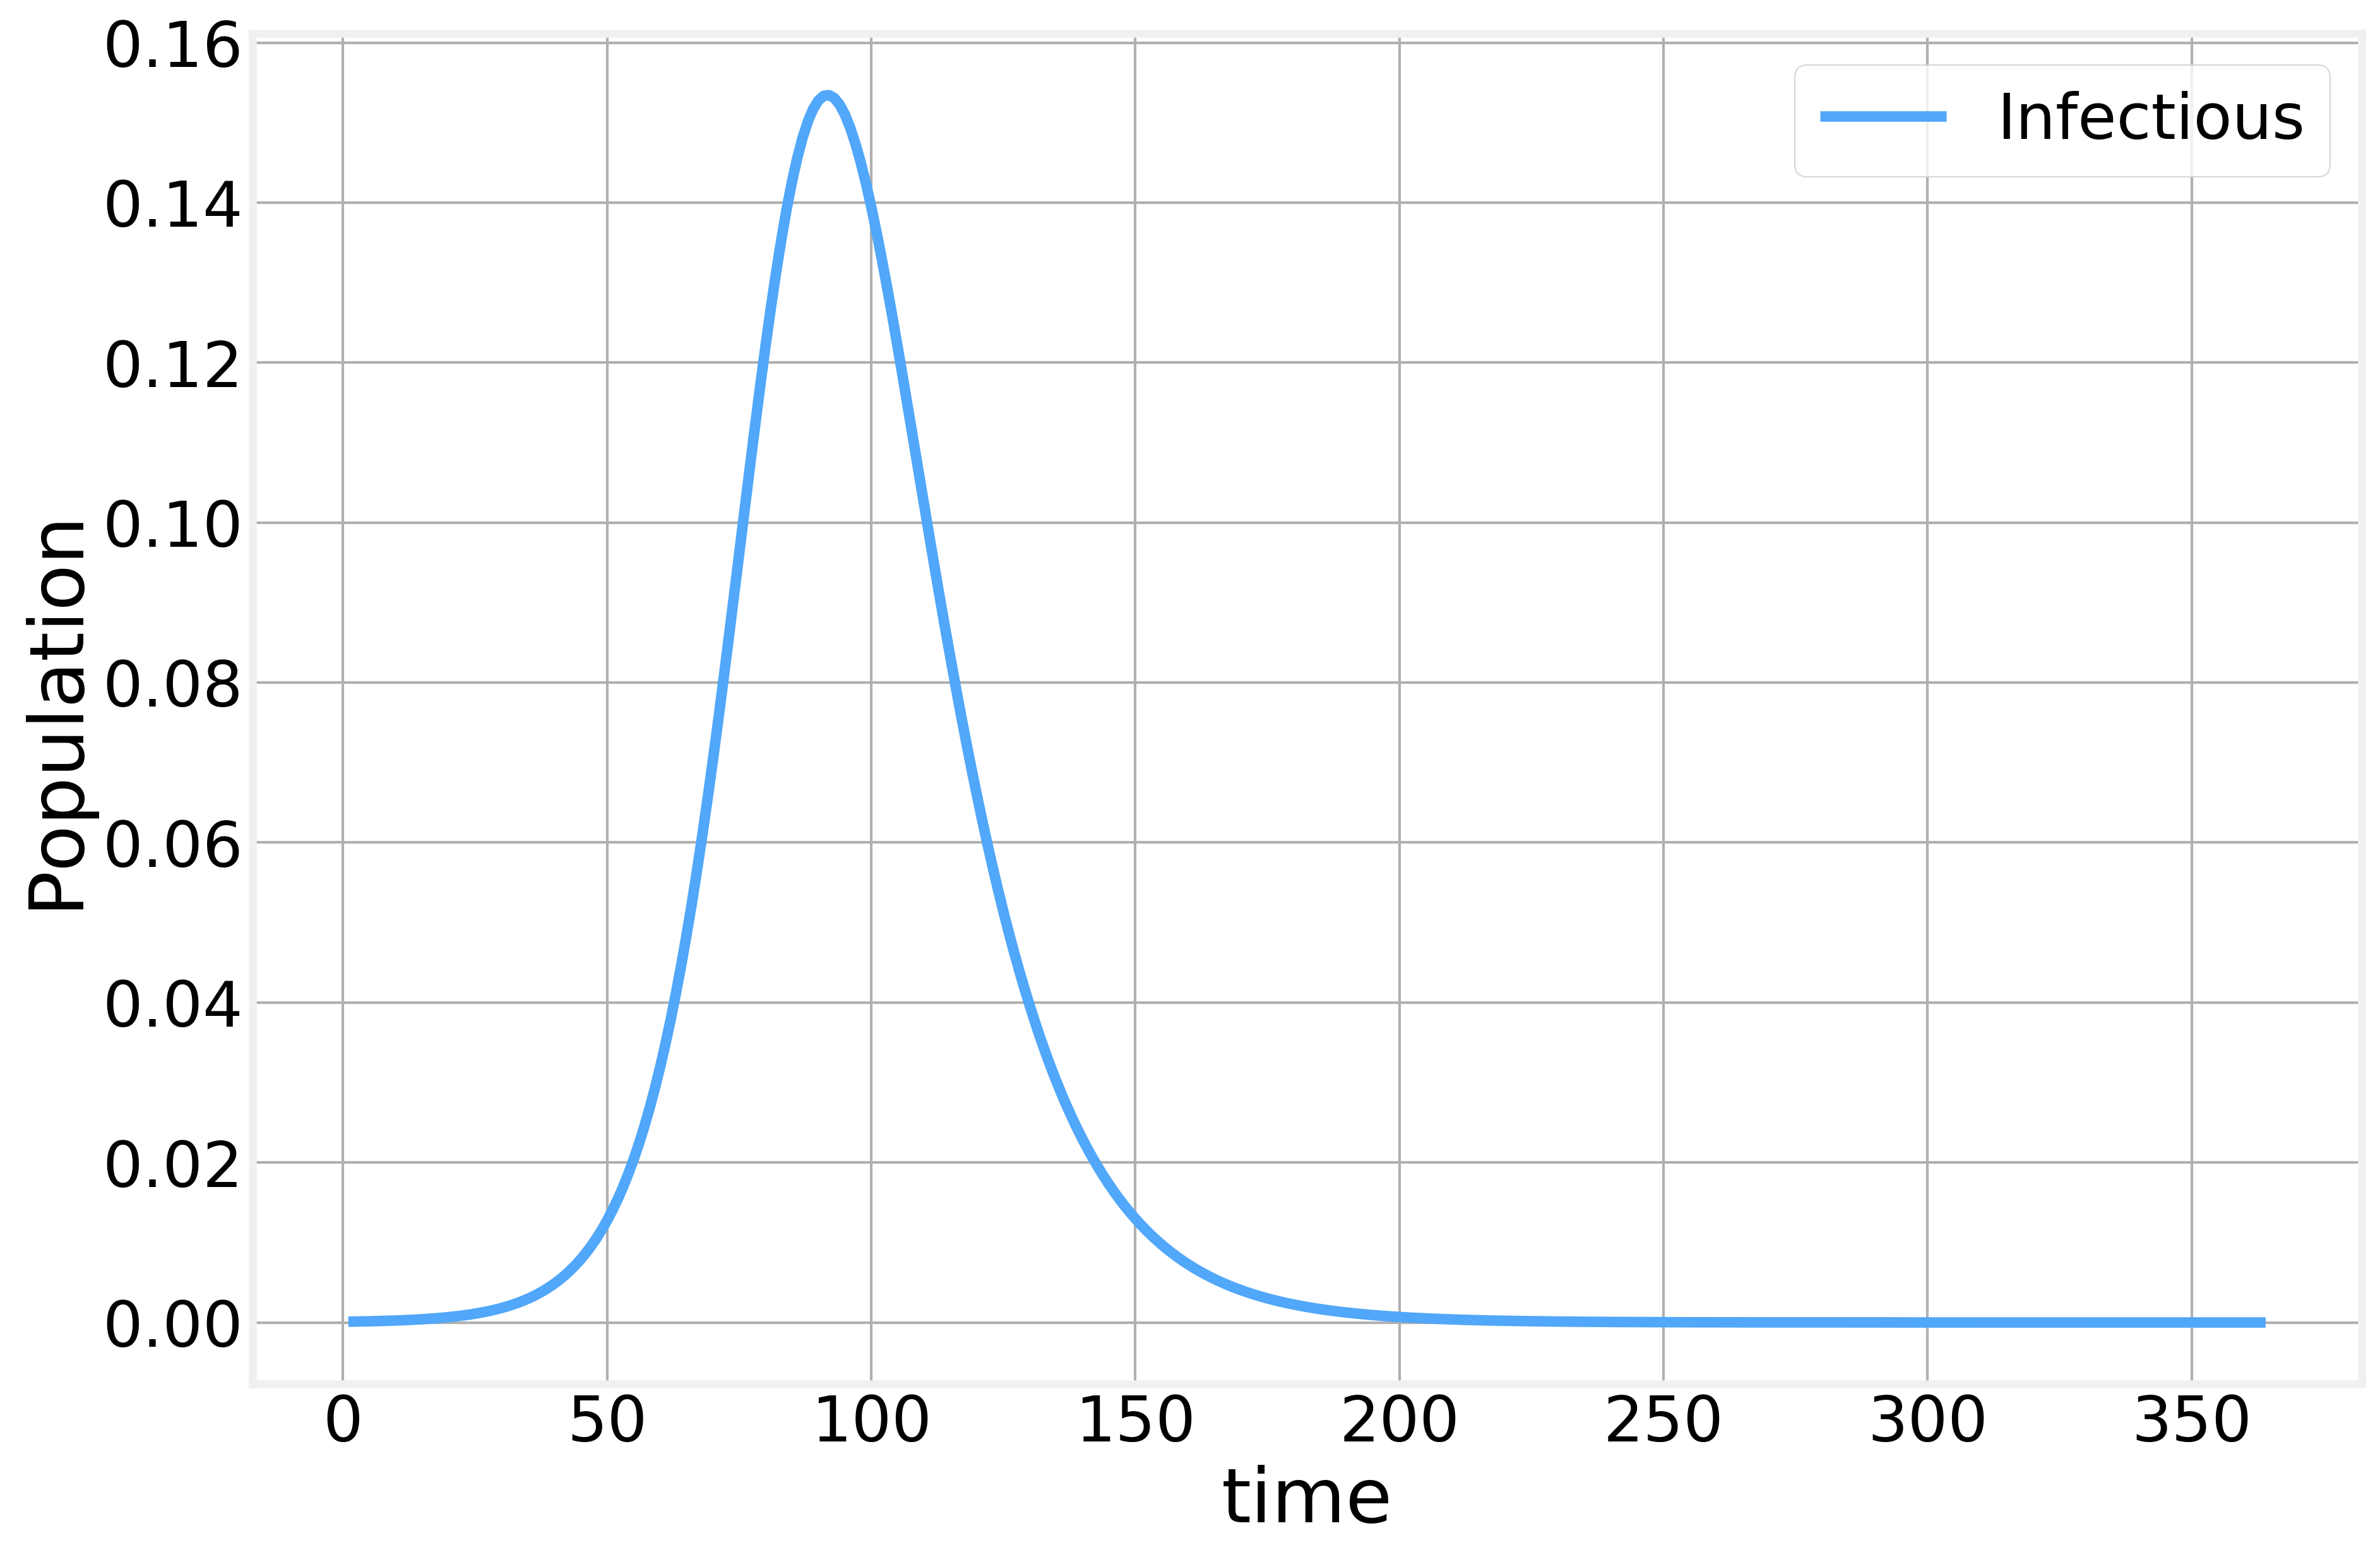

In [12]:
ax=(SIR.I/N).plot(label='Infectious')
ax.set_xlabel('time')
ax.set_ylabel('Population')
ax.legend()

## Confirmed cases

If you've been paying attention to the news, the numbers of confirmed cases you've been seeing about CoVID19 correspond to, some fraction, $\phi$ of the total number of people that got infected up to that point. We can calculate that easily by simply seeing how many "healthy" people we lost as a function of time:

$$ Confirmed = \phi\left(N-S\right)$$

If, say, $\phi=10\%$ of everyone who gets infected is takes the test, then:

Text(0, 0.5, 'Confirmed Cases')

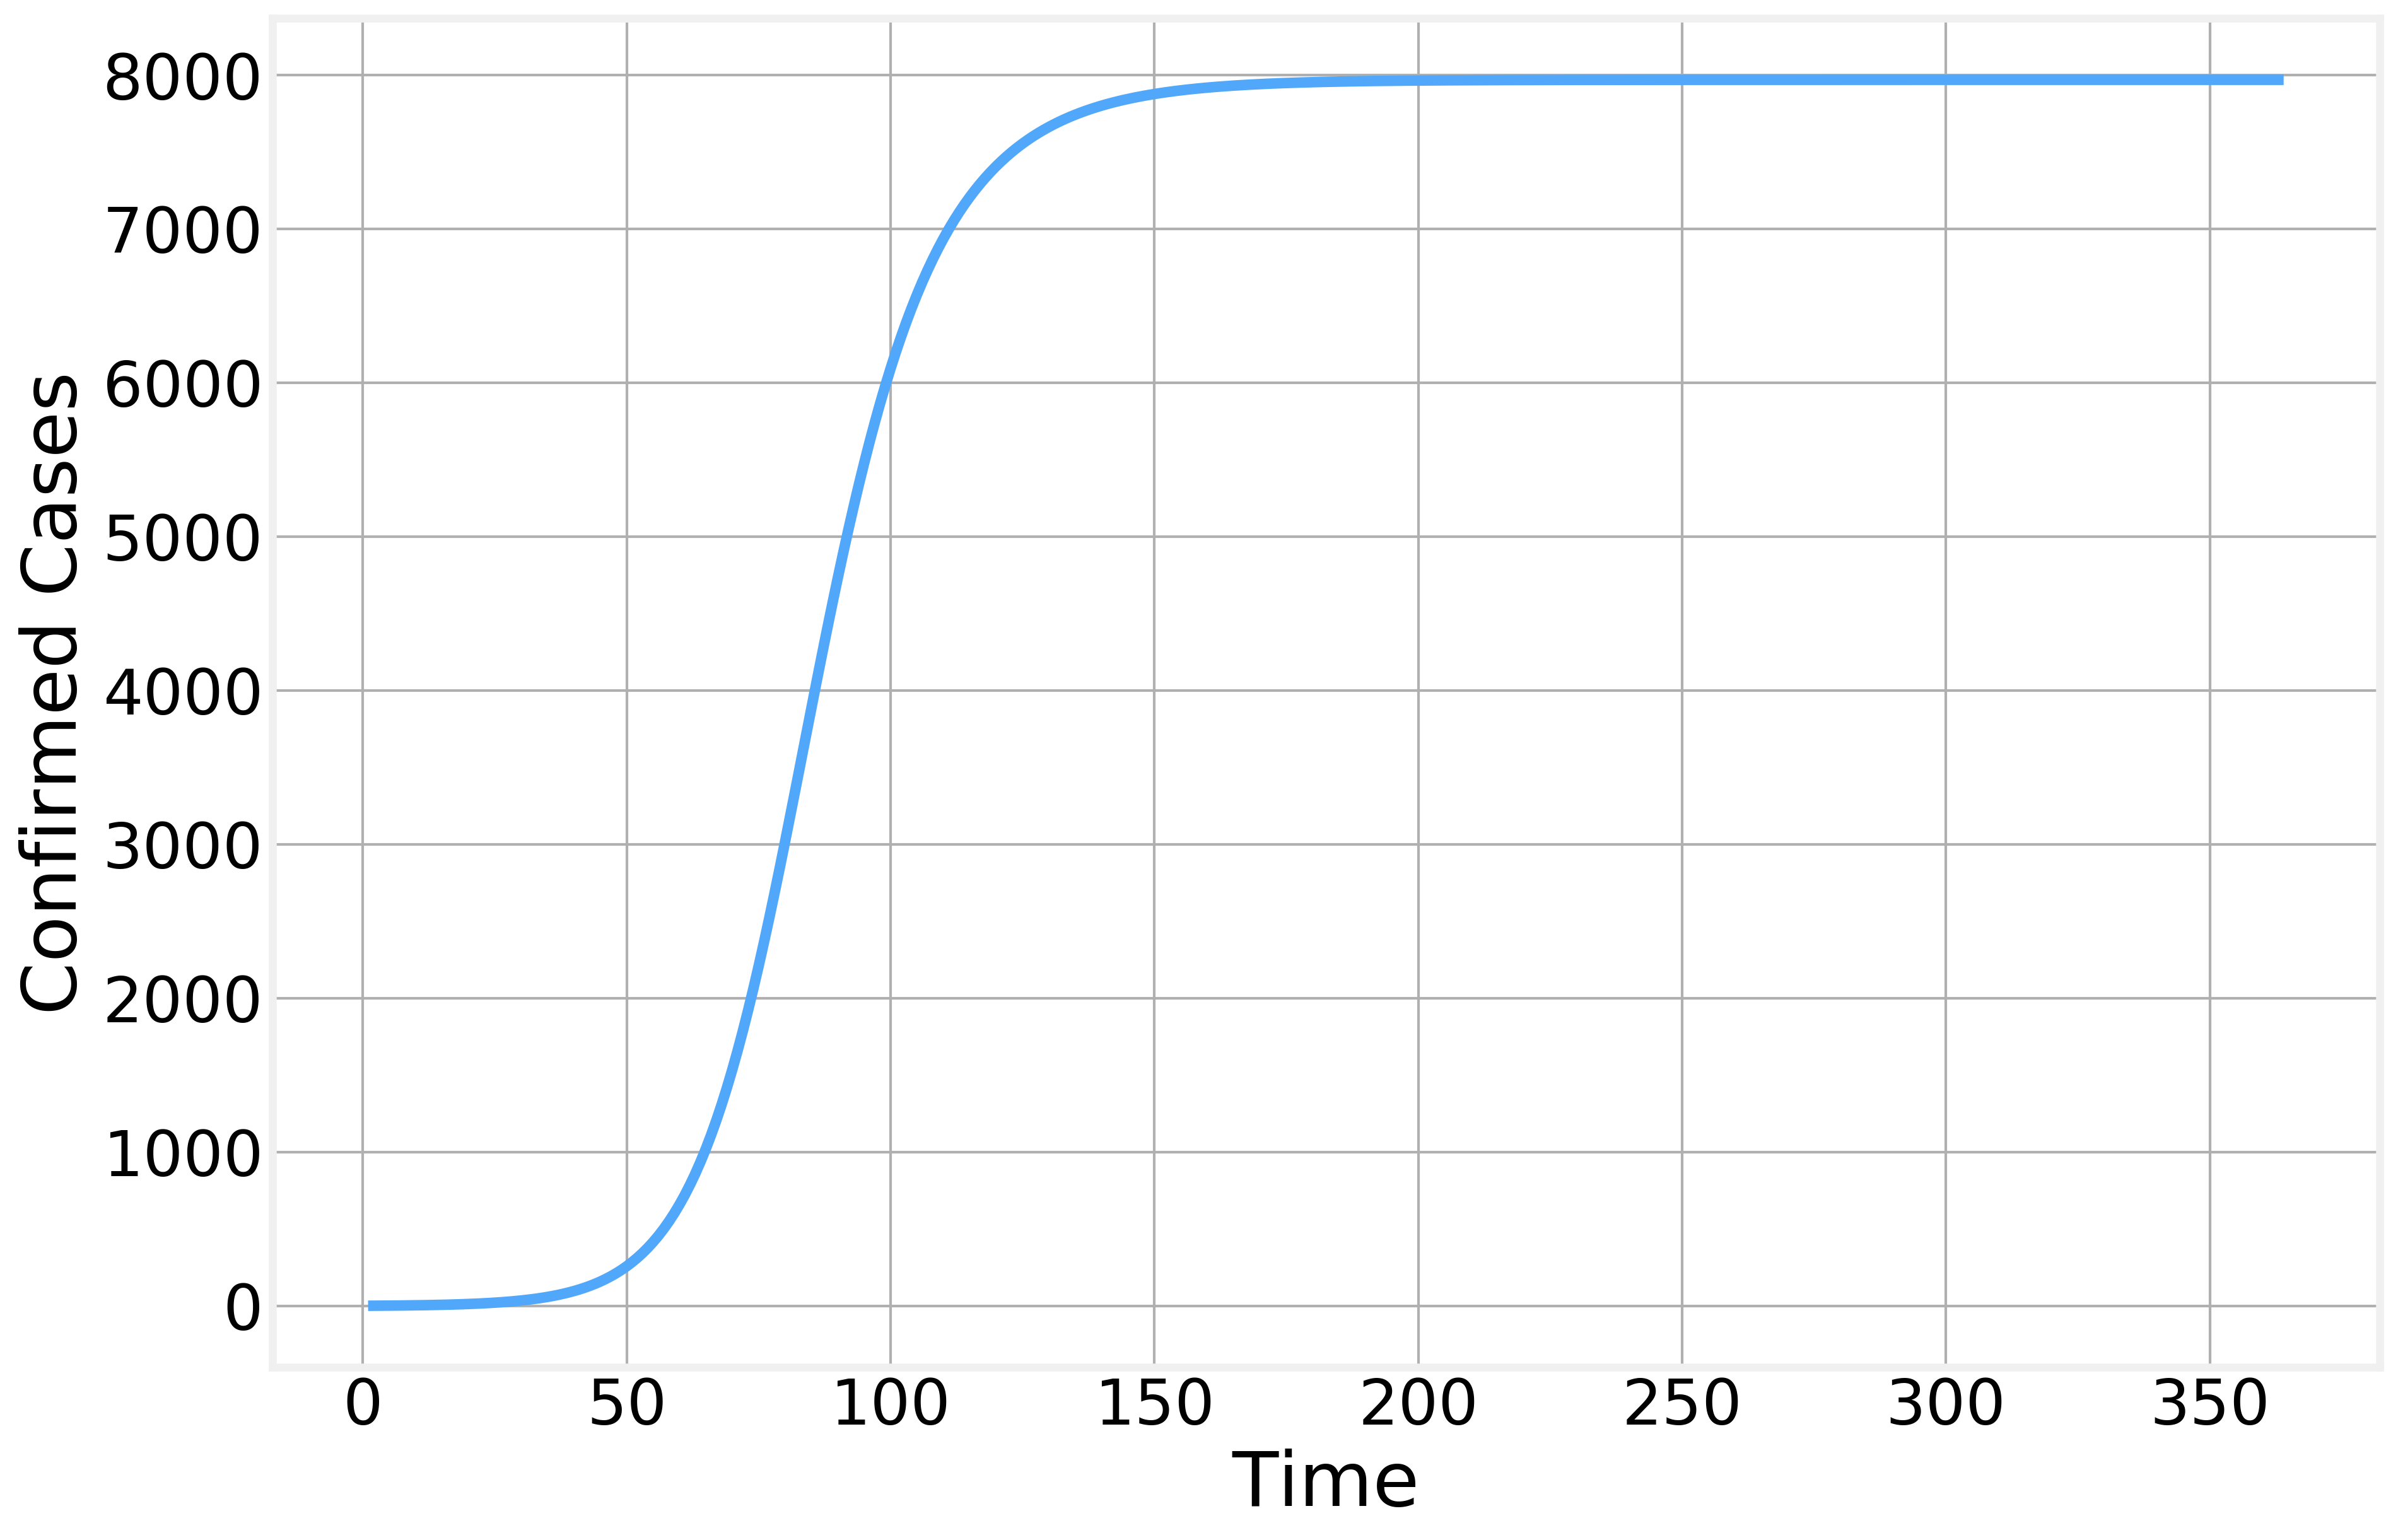

In [13]:
phi = 0.1
ax = (phi*(N-SIR.S)).plot()
ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')

And the number of recovered cases follows a similar path, with a few days lag. Here we apply the same factor of $\phi$ to the number of recovered, since in principle, those would be the only ones we could observe recovering.

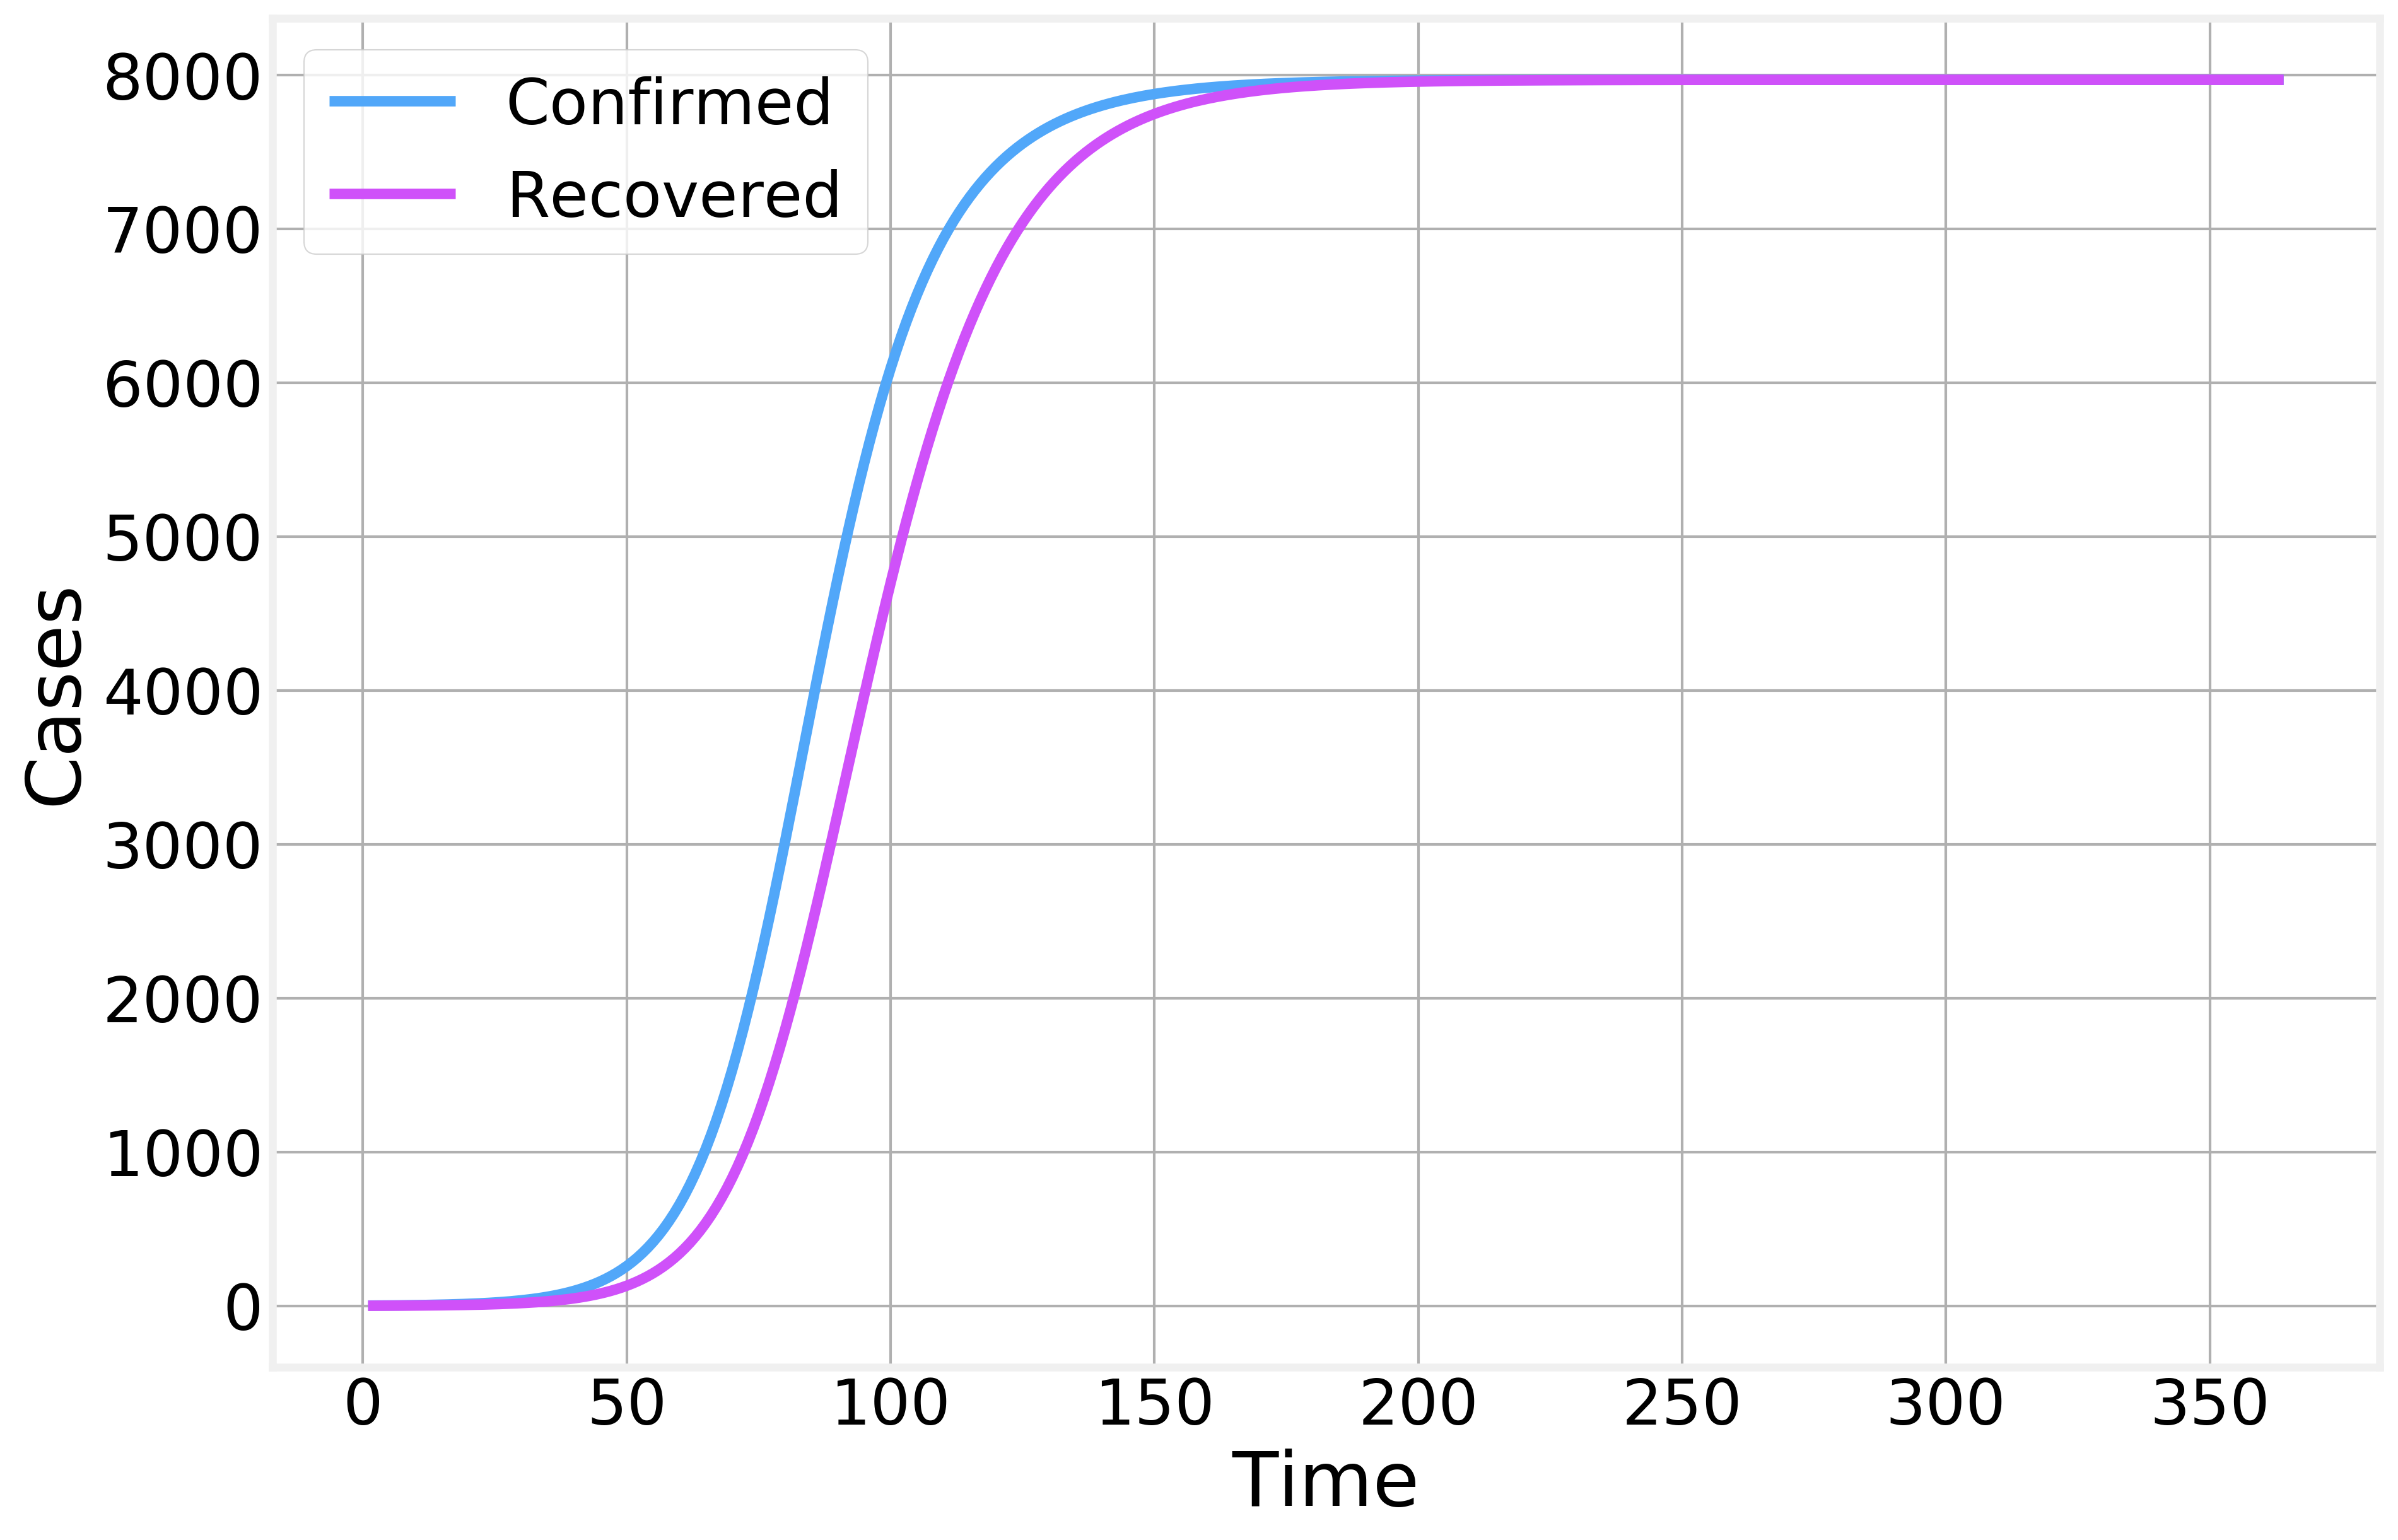

In [14]:
phi = 0.1
ax = (phi*(N-SIR.S)).plot(label='Confirmed')
(phi*SIR.R).plot(ax=ax, label='Recovered')
ax.set_xlabel('Time')
ax.set_ylabel('Cases')
ax.legend()

For the sake of clarity I'm making the simplifying assumption that test are instantanous and happen as soon as the infection happens. This is __slightly__ unrealistic :) 

And indeed the numbers start off growing exponentially

(0, 50)

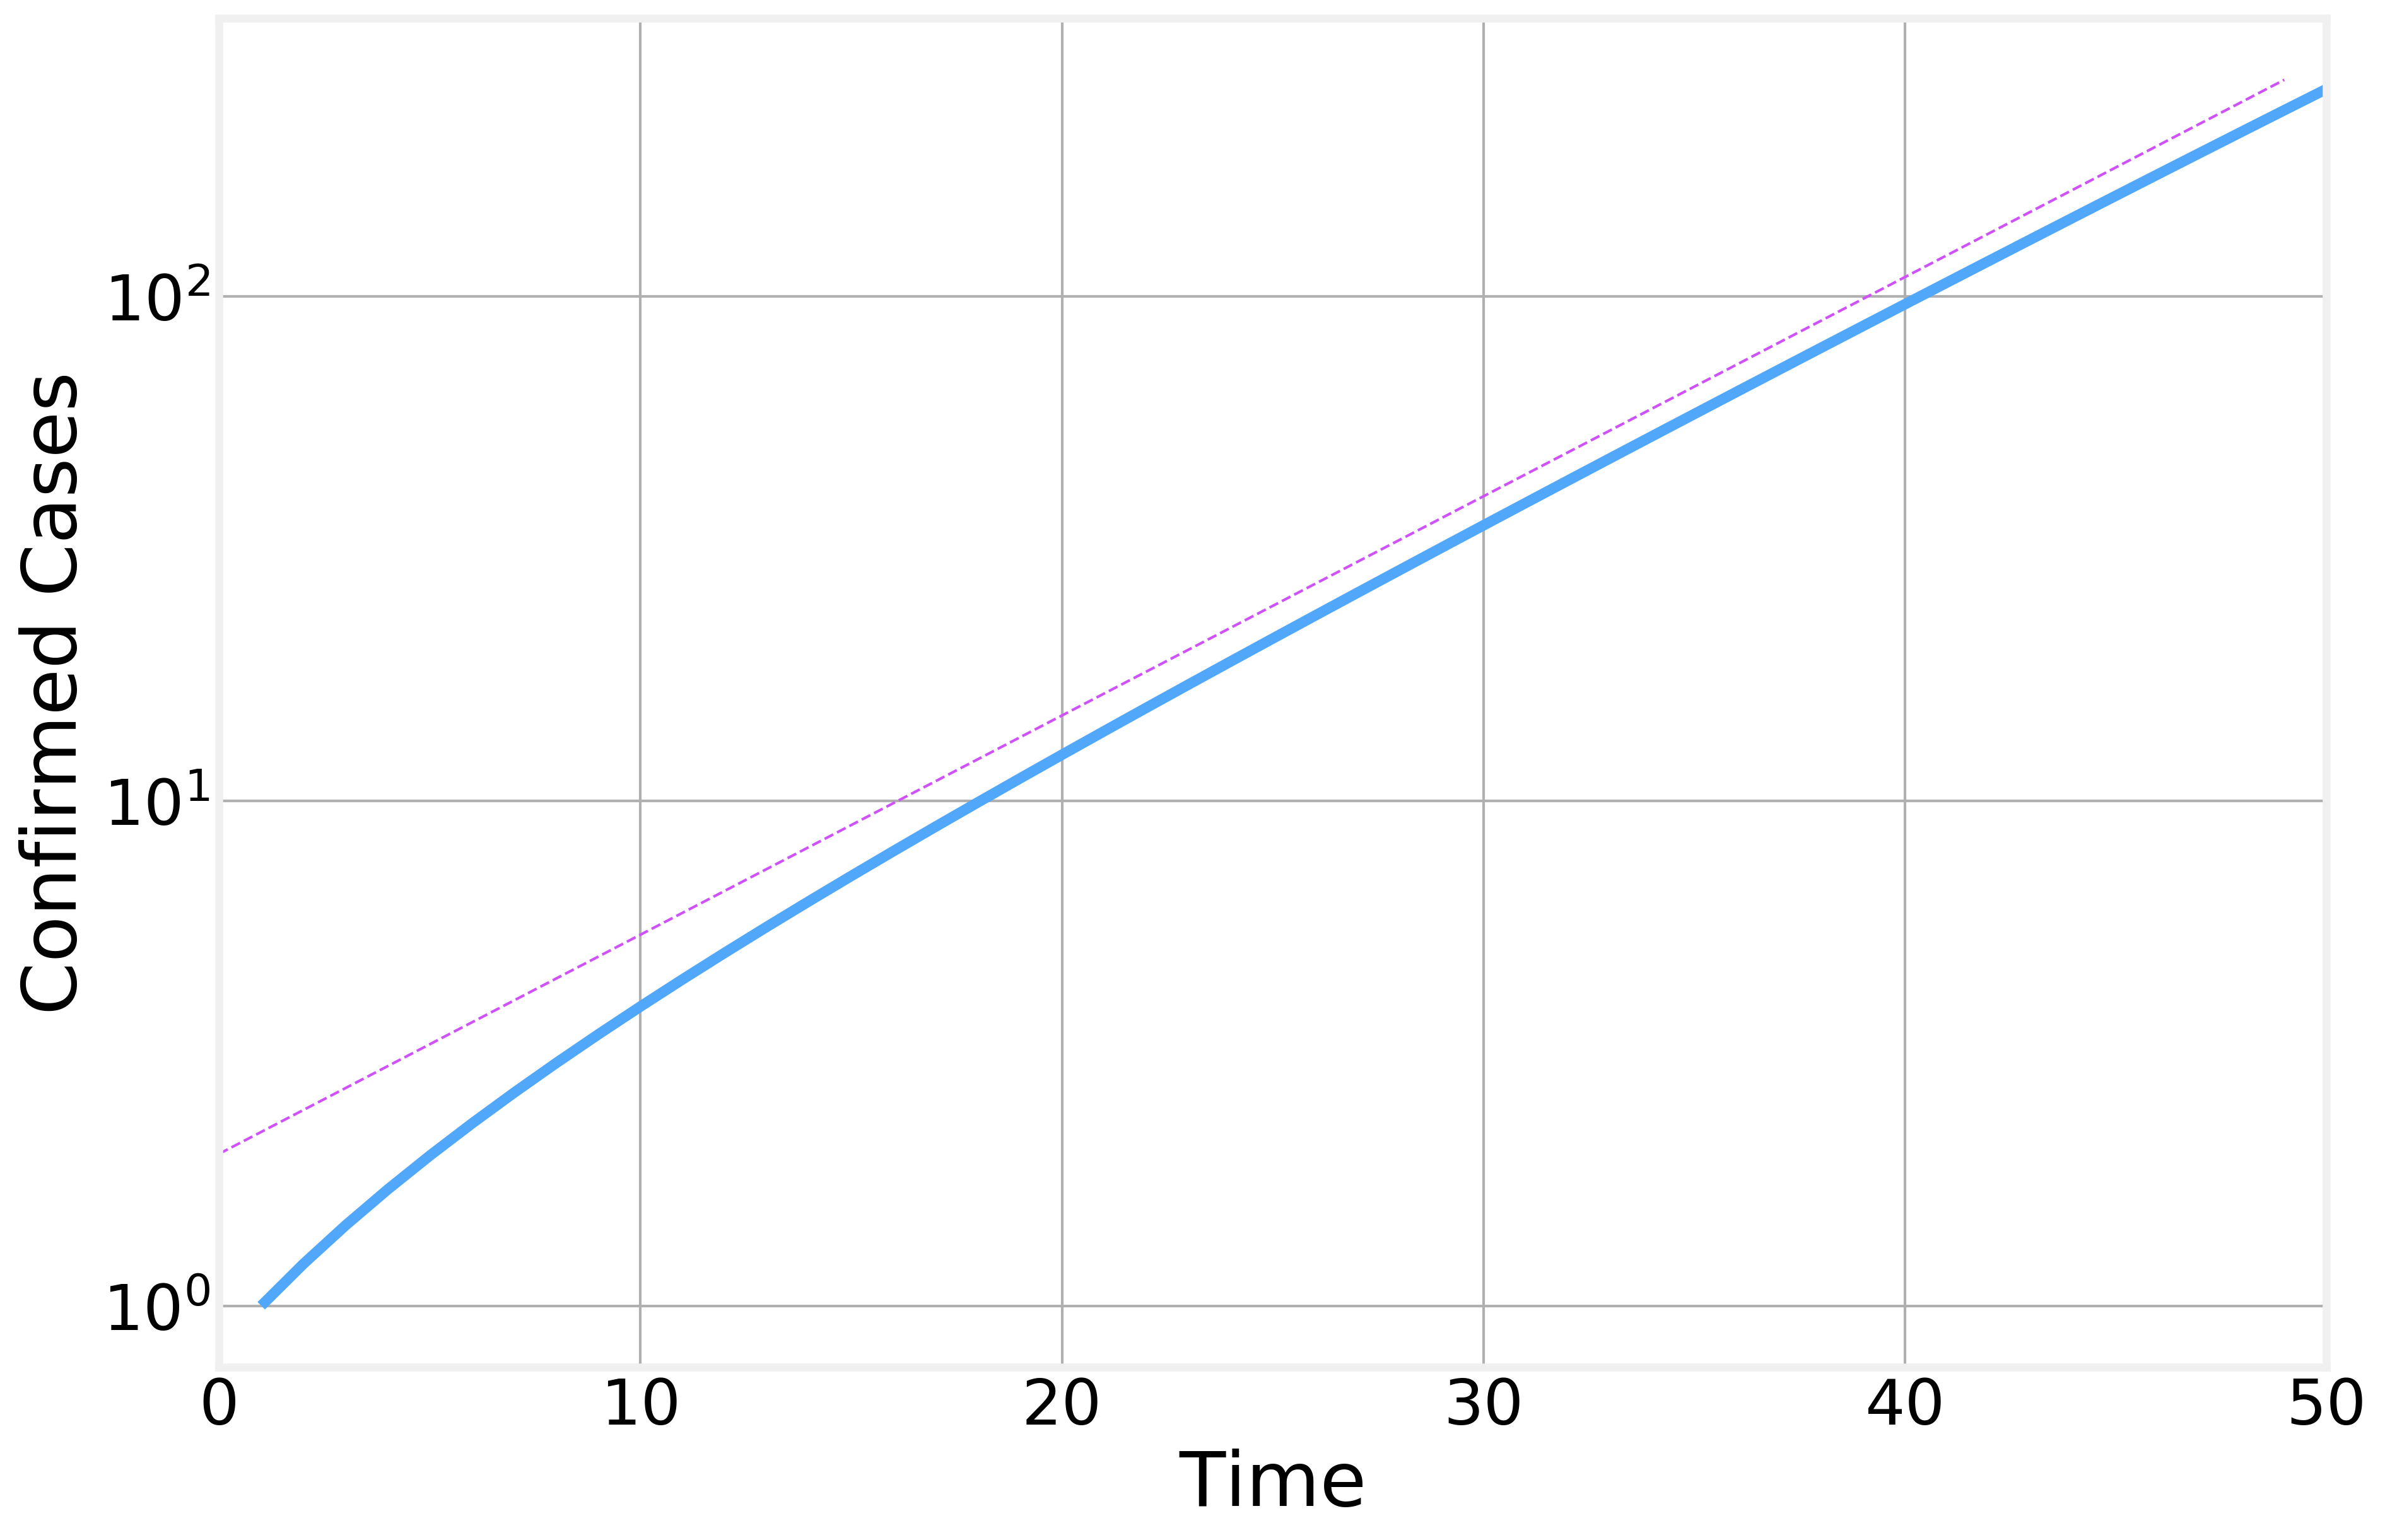

In [15]:
phi = 0.1
ax = (phi*(N-SIR.S[:50])).plot()
t = np.arange(0, 50, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=1, linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.set_xlim(0, 50)

And we easily calculate the doubling time

In [16]:
doubling_time = np.log(2)/(beta-mu)
print("Doubling time: %u days" % np.round(doubling_time))

Doubling time: 7 days


## Non-uniform testing

Now let's look at a more realistic case. What if, instead of testing exactly $\phi=10\%$ of the cases, starting imediatly, it takes us a while to ramp up testing? Say, we start at 0 for the first week and smootly ramp up over the course of three weeks to a steady state rate of $\phi$?

In [17]:
phi_t = np.ones(364)*0.1 # The steady state rate
phi_t[:7] = 0 # 0 for the first 7 days
phi_t[7:28] = np.linspace(0, 0.1, 21) # ramp up over 3 weeks

Now our curves looks a bit more interesting.

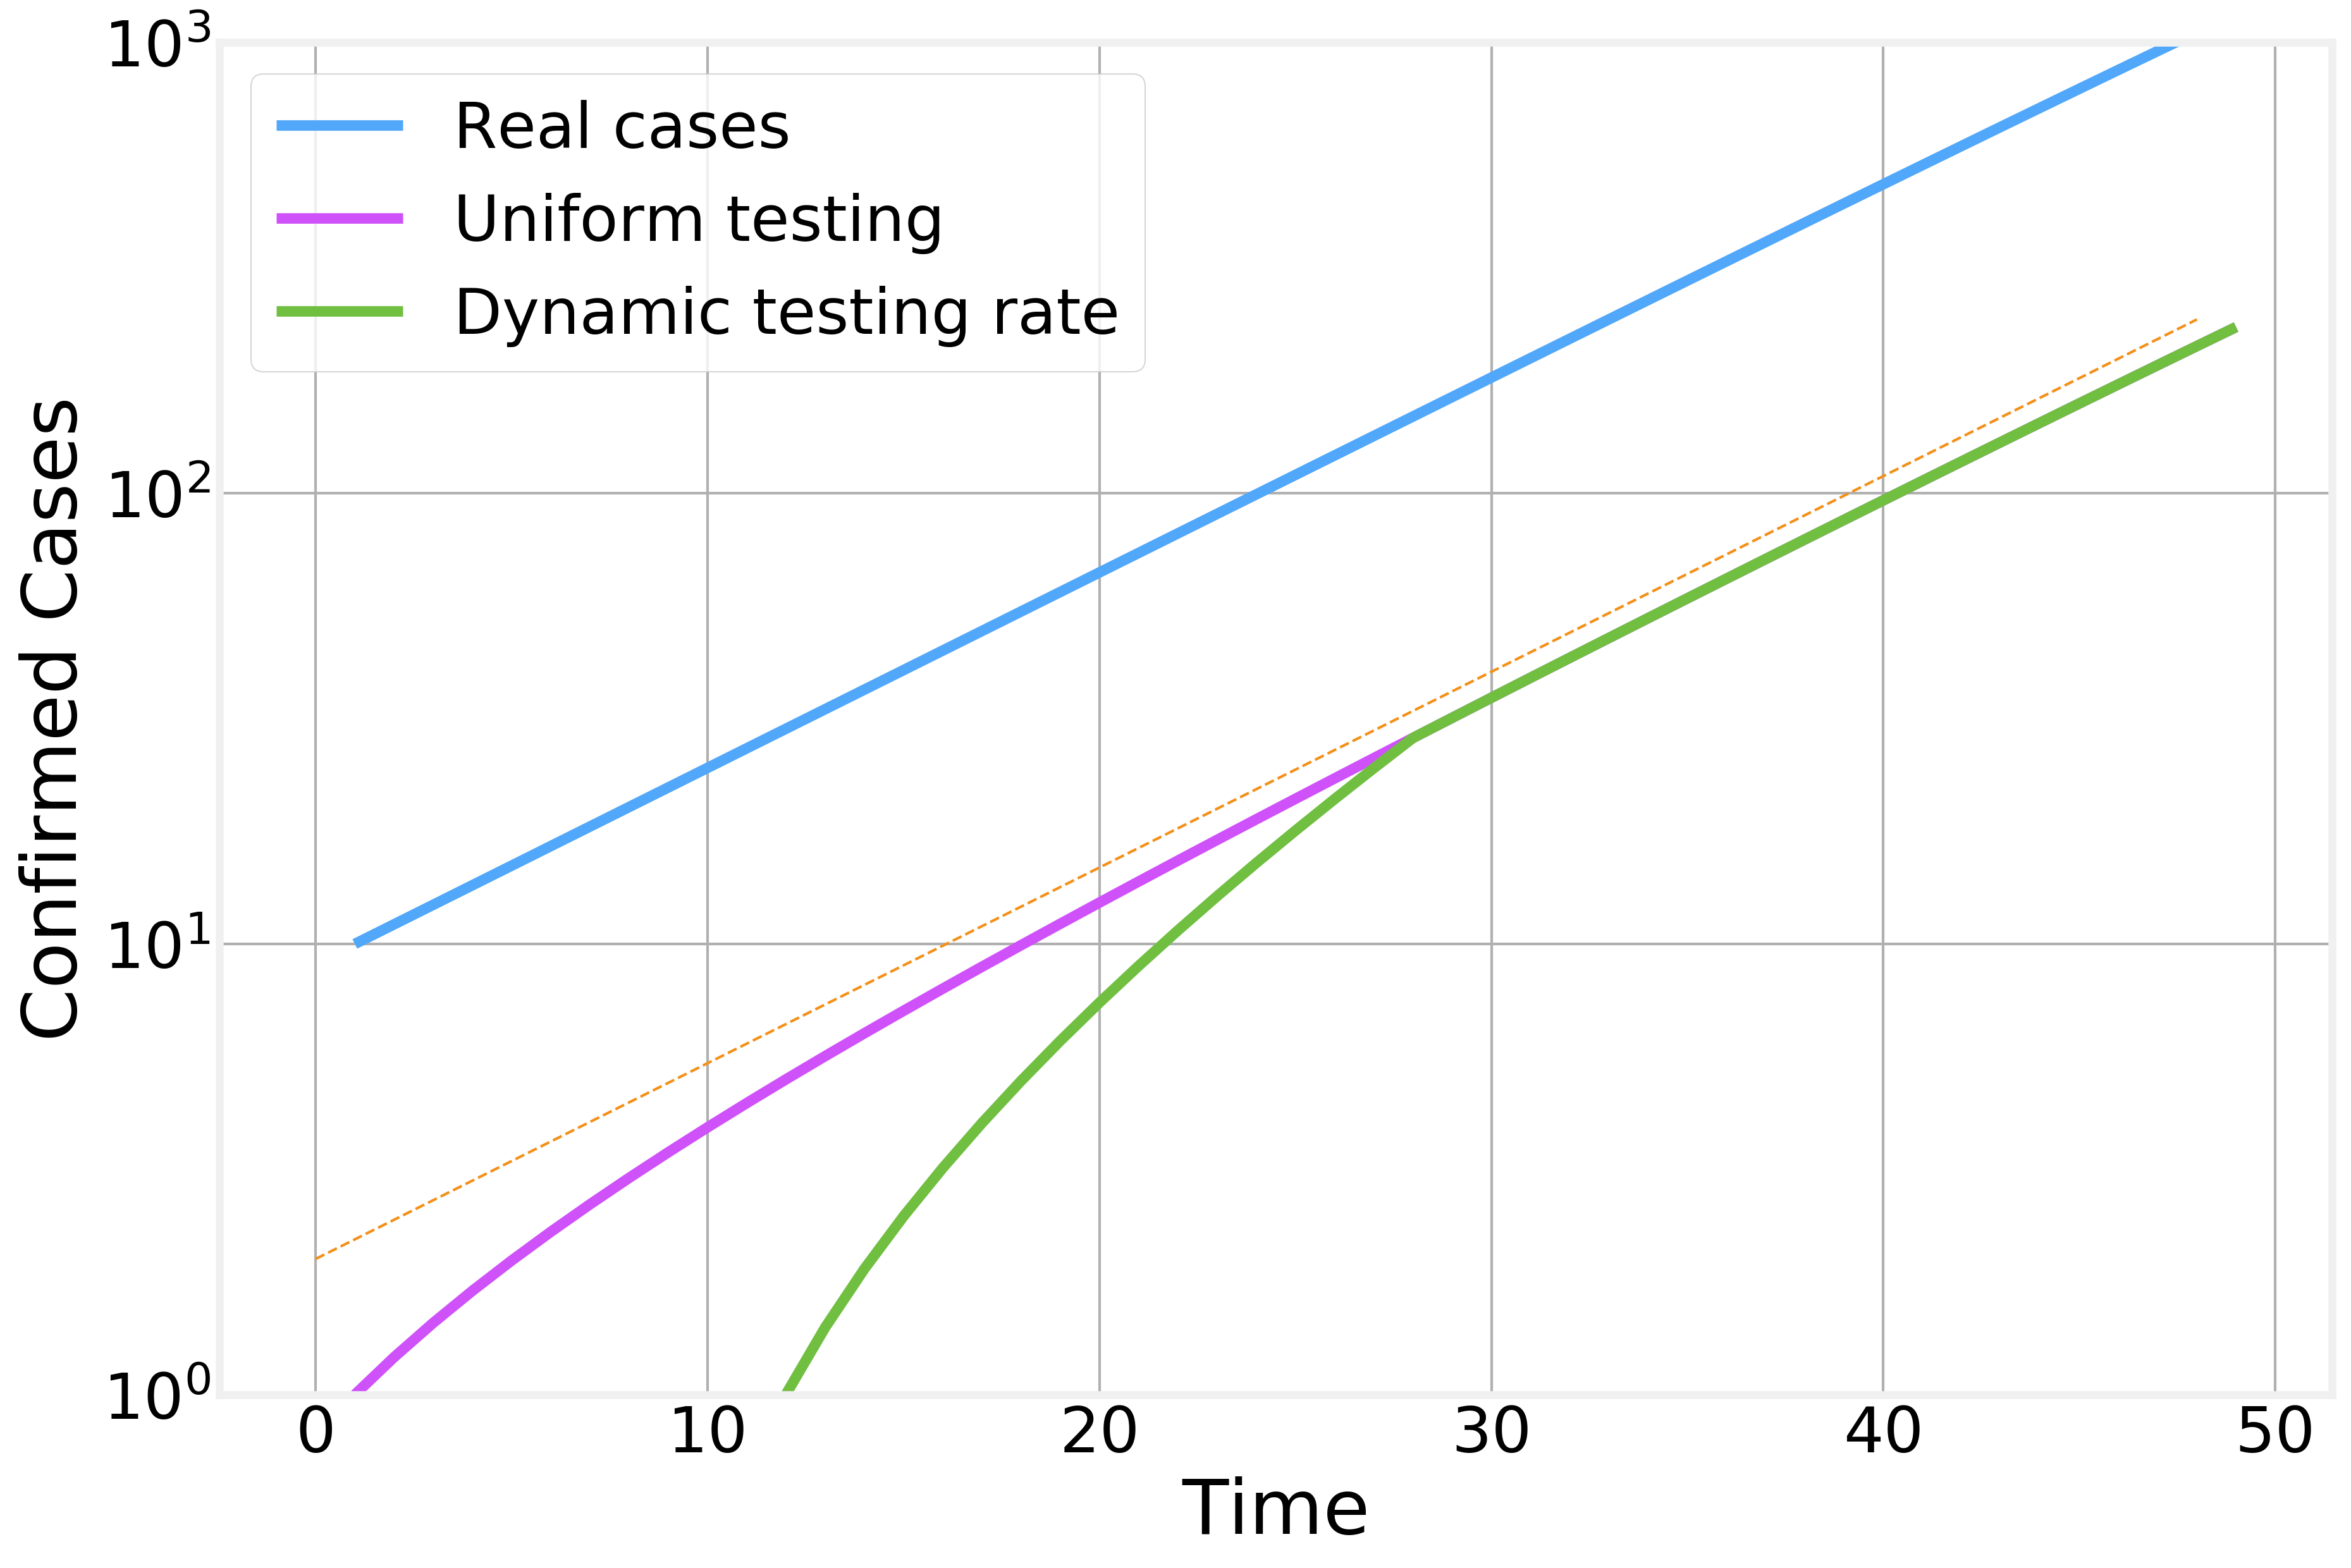

In [18]:
ax = SIR.I.iloc[:49].plot(label='Real cases')
(phi*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Uniform testing')
(phi_t*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Dynamic testing rate')

t = np.arange(0, 49, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=1, linestyle='--')
ax.set_ylim(1, 1000)
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.set_yscale('log')

Two things should be noted here:

- By the time we detect the first case, on day 11, the real number of cases is already several dozen
- The increase in testing rate gets muddled together with the increase in the number of cases to look like a much faster increase

Naturally, the opposite is also true, if we decrease the number of tests, we see an artificial slowing down of the number of cases

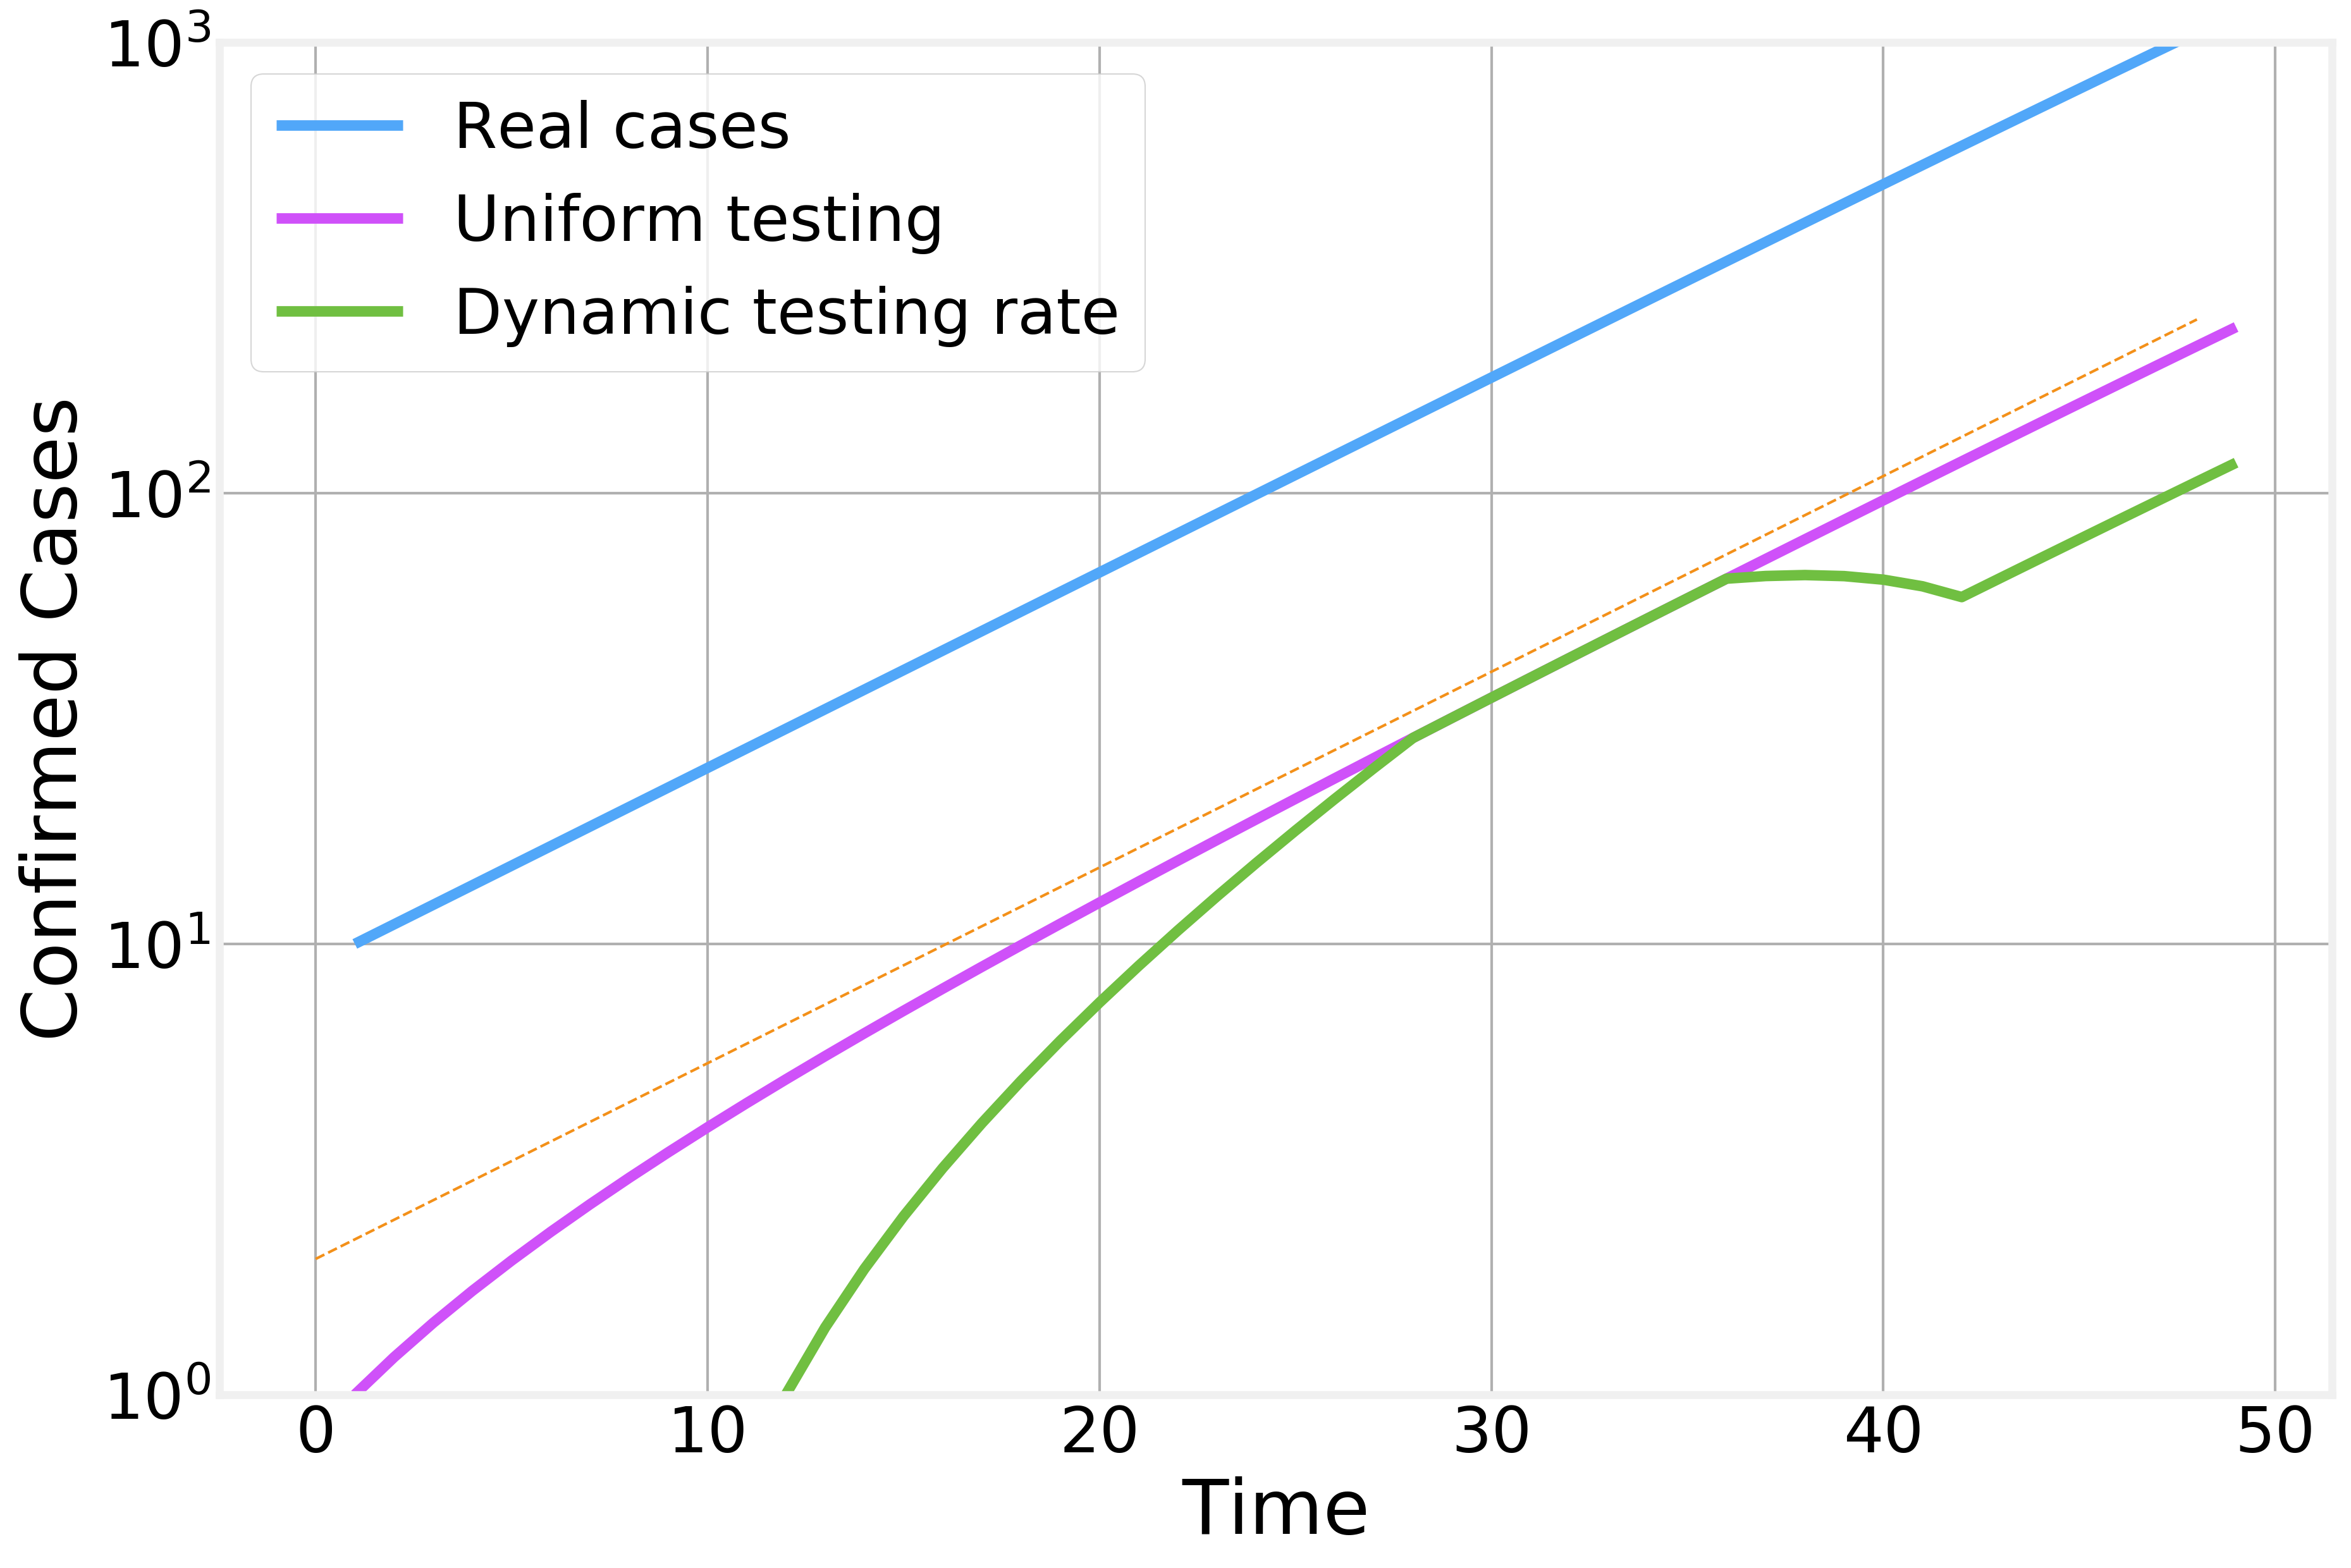

In [19]:
phi_t[35:42]=np.linspace(0.1, 0.05, 7) # Gradually reduce the number of tests in the 5th week
phi_t[42:] *= 0.5 # stay at 0.05 for the rest of the time

ax = SIR.I.iloc[:49].plot(label='Real cases')
(phi*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Uniform testing')
(phi_t*(N-SIR.S)).iloc[:49].plot(ax=ax, label='Dynamic testing rate')

t = np.arange(0, 49, 1)
y = 2*np.exp((beta-mu)*t)
ax.plot(t, y, lw=1, linestyle='--')
ax.set_ylim(1, 1000)
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Confirmed Cases')
ax.set_yscale('log')

In practice, the testing rate is not fixed and changes over time due to supply availability, policy changes, etc. As a result, trying to fit exponential curves to the numbers you hear in the news is at best, misleading.

## Dynamical lags

Another issue that can easily complicate things is the fact that epidemic models work a bit like conveyer belts. Susceptible get fed on one end, become infectious and eventually Recovered come out the other end. 

We calculate the number of __new infections__ as a function of time by looking at the change in the number of susceptibles and compare with the total number of currently infectious people. Due to the difference in number, we normalize each curve by it's maximum

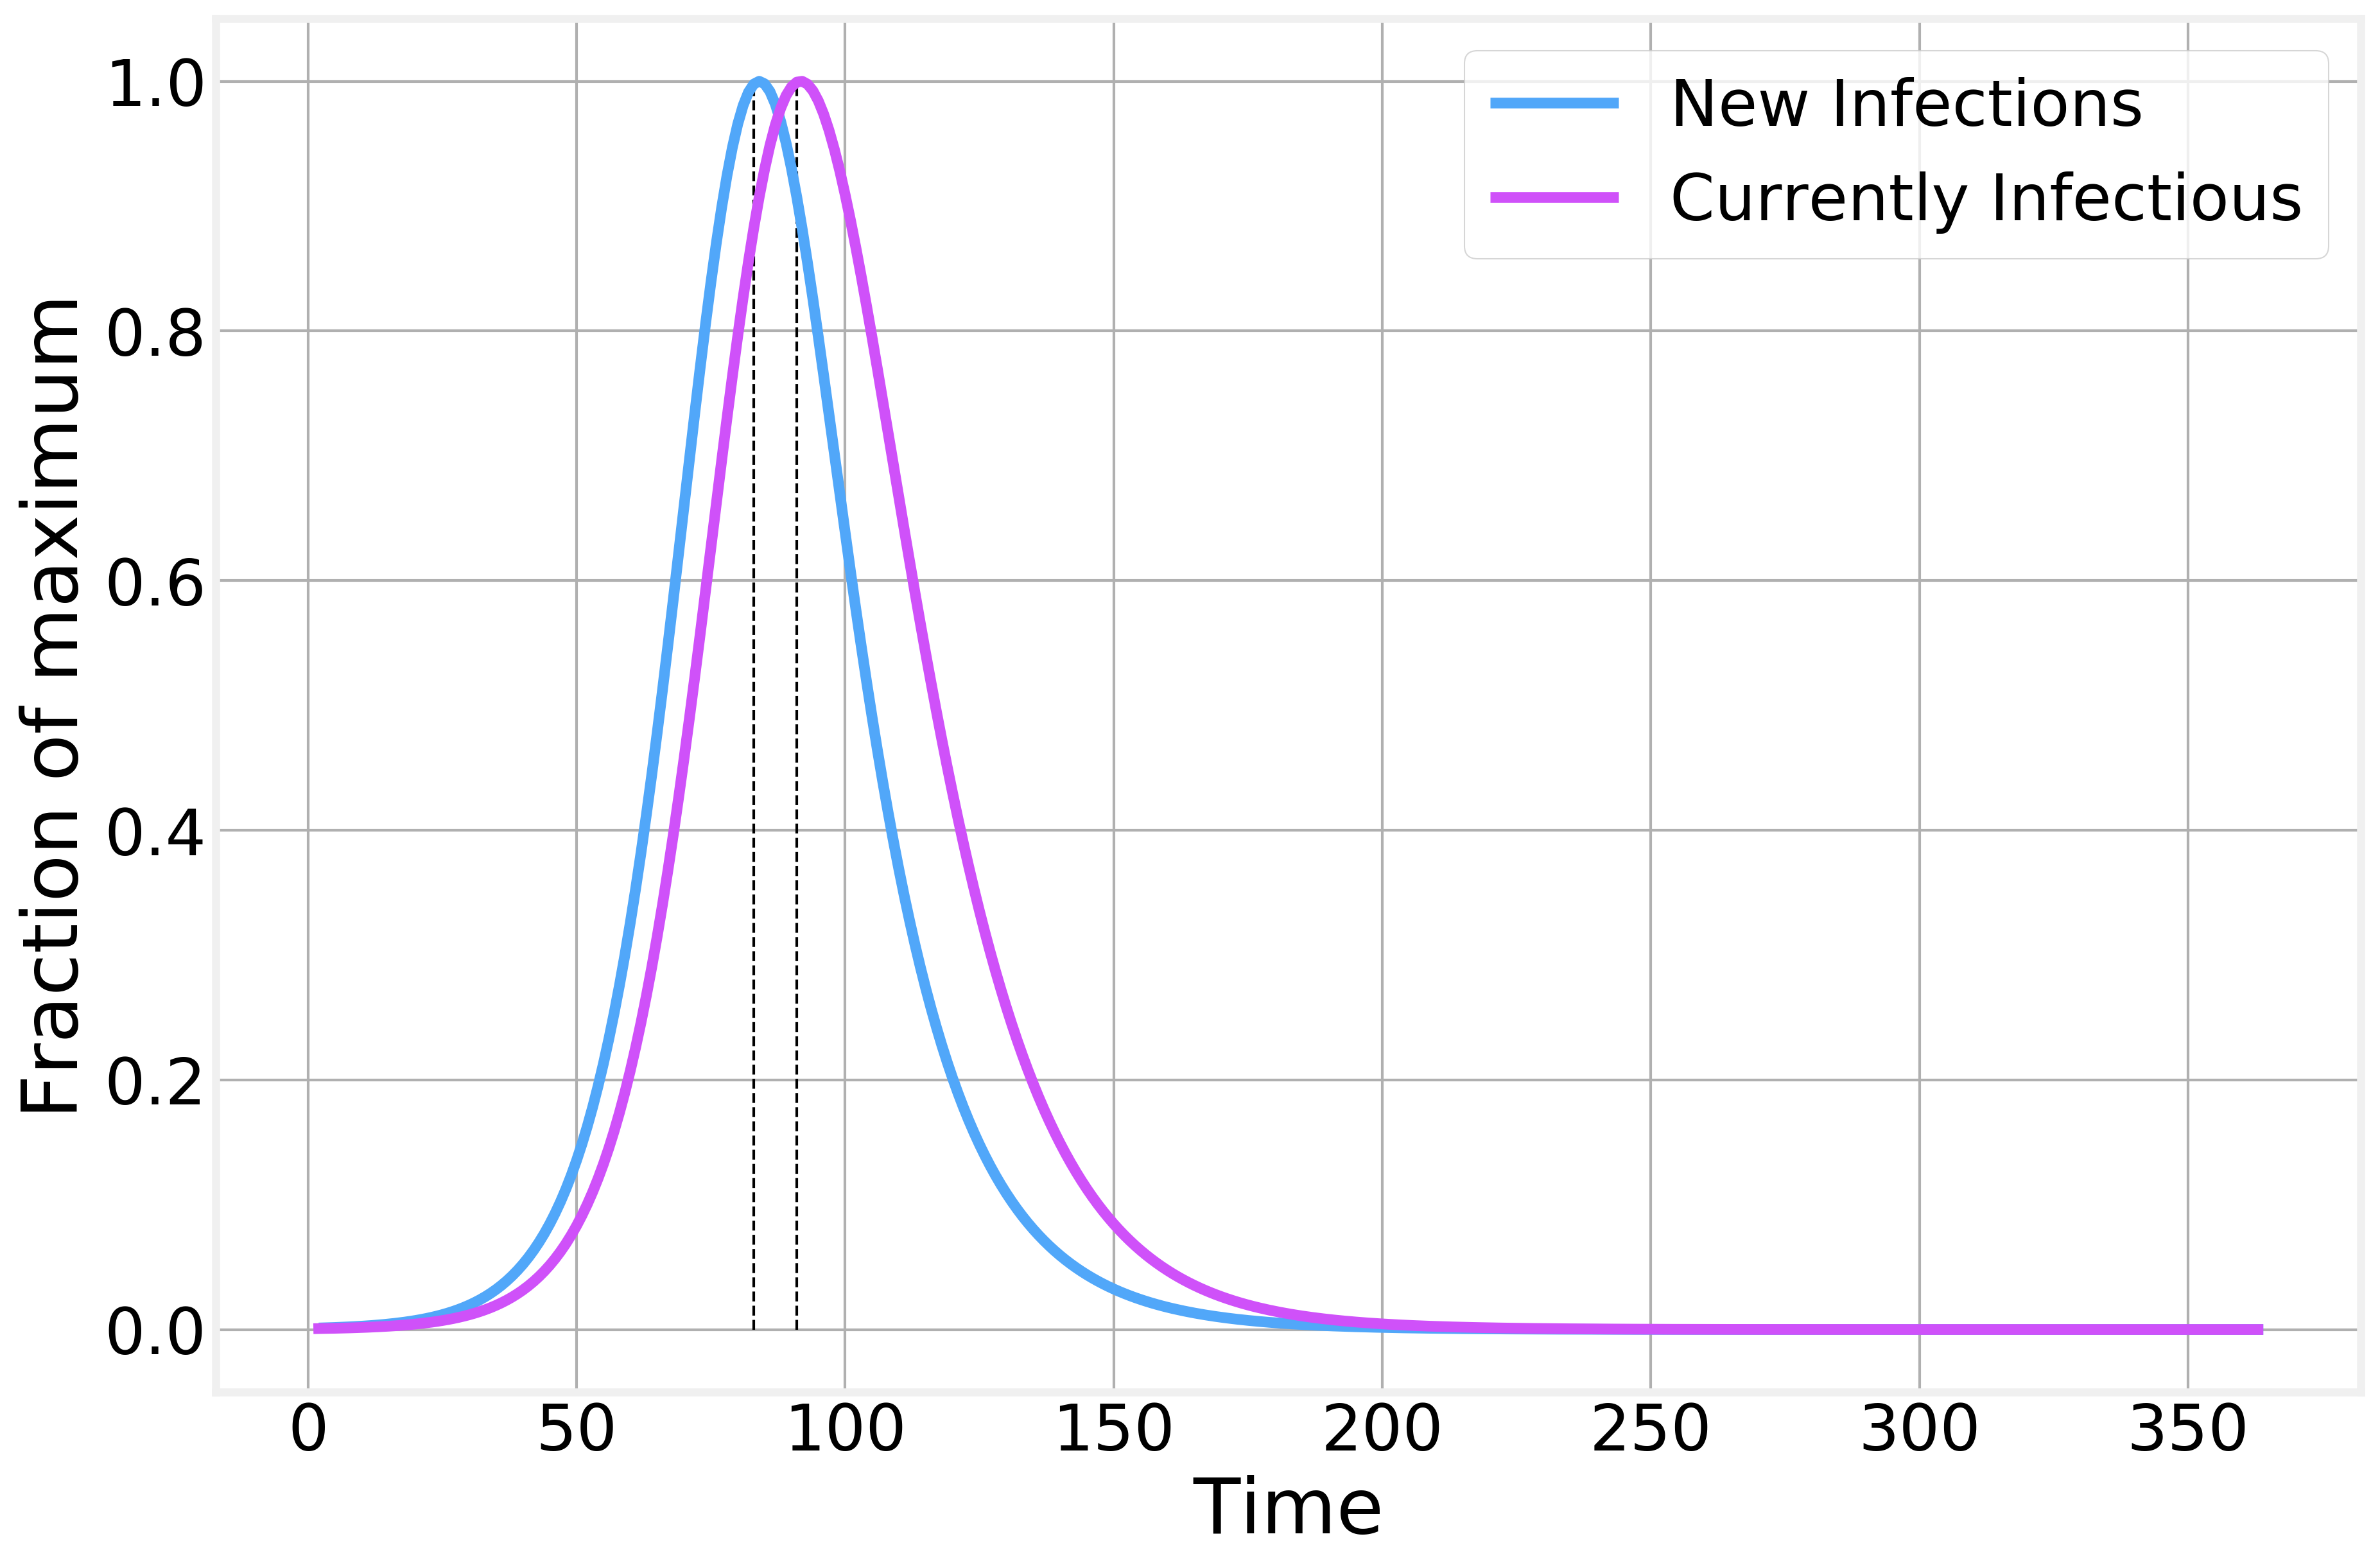

In [31]:
new_infections = (-SIR.S).diff(1)

new_infections_max = new_infections.argmax()
infectious_max = SIR.I.argmax()

ax=(new_infections/new_infections.max()).plot(label='New Infections')
(SIR.I/SIR.I.max()).plot(ax=ax, label='Currently Infectious')
ax.vlines(x=[new_infections_max, infectious_max], ymin=0, ymax=1, lw=1, linestyle='--')
ax.set_ylabel('Fraction of maximum')
ax.set_xlabel('Time')
ax.legend()

As we can see, there's a clear lag between the point as the rate of new infectious starts decreasing and the number of currently infectious individuals starts decreasing as well.

## Lockdown

A consequence of this is that even if you completely cut the supply of Susceptibles who become Infected it takes some time for the effects to be seen. We illustrate this more clearly by implementing a simple lockdown strategy. Starting at time 75, we implement our lockdown strategy and completly stop new infections from occurring. We do this by replacing the epidemic model with one where people are only allowed to recover.

We start with the original SIR model as before and integrating for the first 75 days

In [37]:
beta = 0.2
mu = 0.1

SIR2 = EpiModel()
SIR2.add_interaction('S', 'I', 'I', beta)
SIR2.add_spontaneous('I', 'R', mu)

SIR2.integrate(75, S=N-I0, I=I0, R=0)

Now we create new model with just one transition and setting the initial population to be the population at the end of the previous process

In [53]:
Quarantine = EpiModel('SIR')
Quarantine.add_spontaneous('I', 'R', mu)

population = SIR2.values_.iloc[-1]
S0 = population.S
I0 = population.I
R0 = population.R

Quarantine.integrate(365-74, S=S0, I=I0, R=R0)

In [54]:
Quarantine

Epidemic Model with 3 compartments and 1 transitions:

I -> R 0.100000

Now we compbine the results from the two models

In [55]:
values = pd.concat([SIR2.values_, Quarantine.values_], axis=0, ignore_index=True)

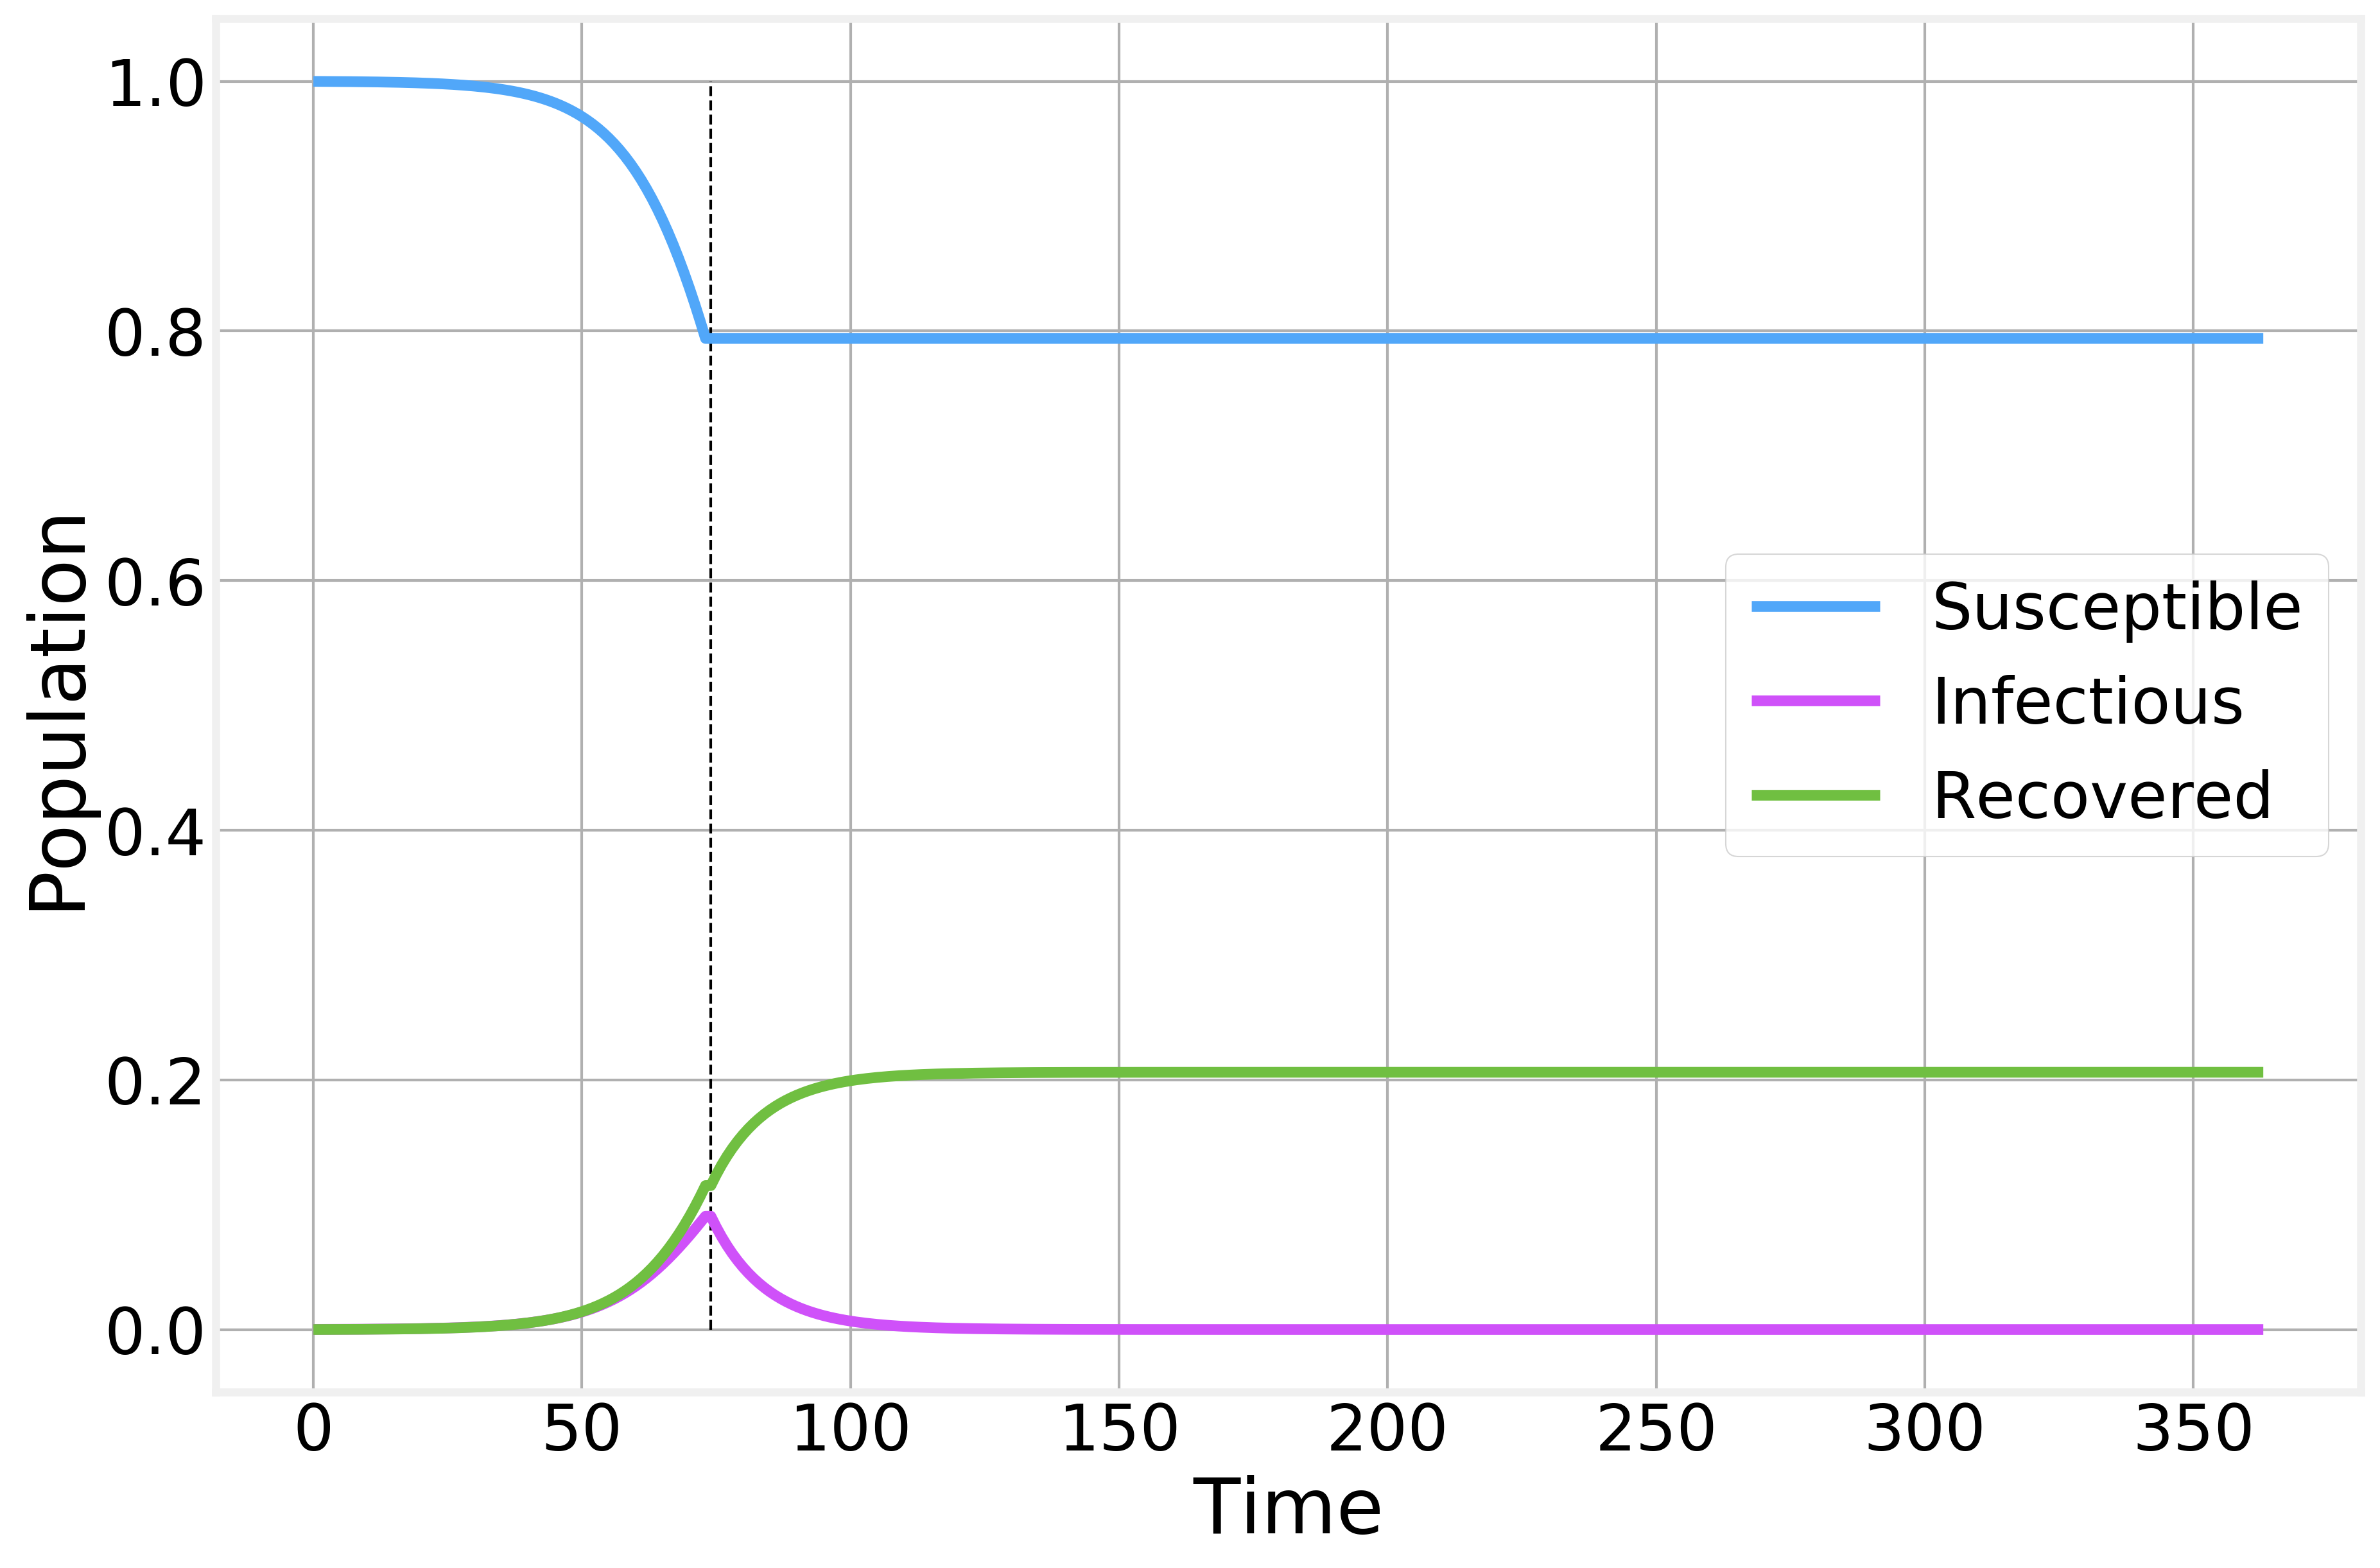

In [56]:
ax = (values/N).plot()
ax.vlines(x=74, ymax=1, ymin=0, lw=1, linestyle='--')
ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

Even in this idealized scenario it still takes ~25 days before all the infectious individual recover and life can go back to normal.

If, instead, we have the more realistic scenario where instead of completely stopping the spread we reduce the the spreading $R_0$ to, say, 0.5 (the perfect scenario was equivalent to $R_0=0$, so that the epidemic becomes non viable, we have:

In [70]:
beta = 0.2/4 # Reduce R0 by 4.
mu = 0.1

Quarantine2 = EpiModel()
Quarantine2.add_interaction('S', 'I', 'I', beta)
Quarantine2.add_spontaneous('I', 'R', mu)

Quarantine2.integrate(365-74, S=S0, I=I0, R=R0)

values2 = pd.concat([SIR2.values_, Quarantine2.values_], axis=0, ignore_index=True)

Now we can compare the two scenarios. Lighter dashed lines representing the perfect case described above

Text(0.5, 1.0, 'Social Distancing')

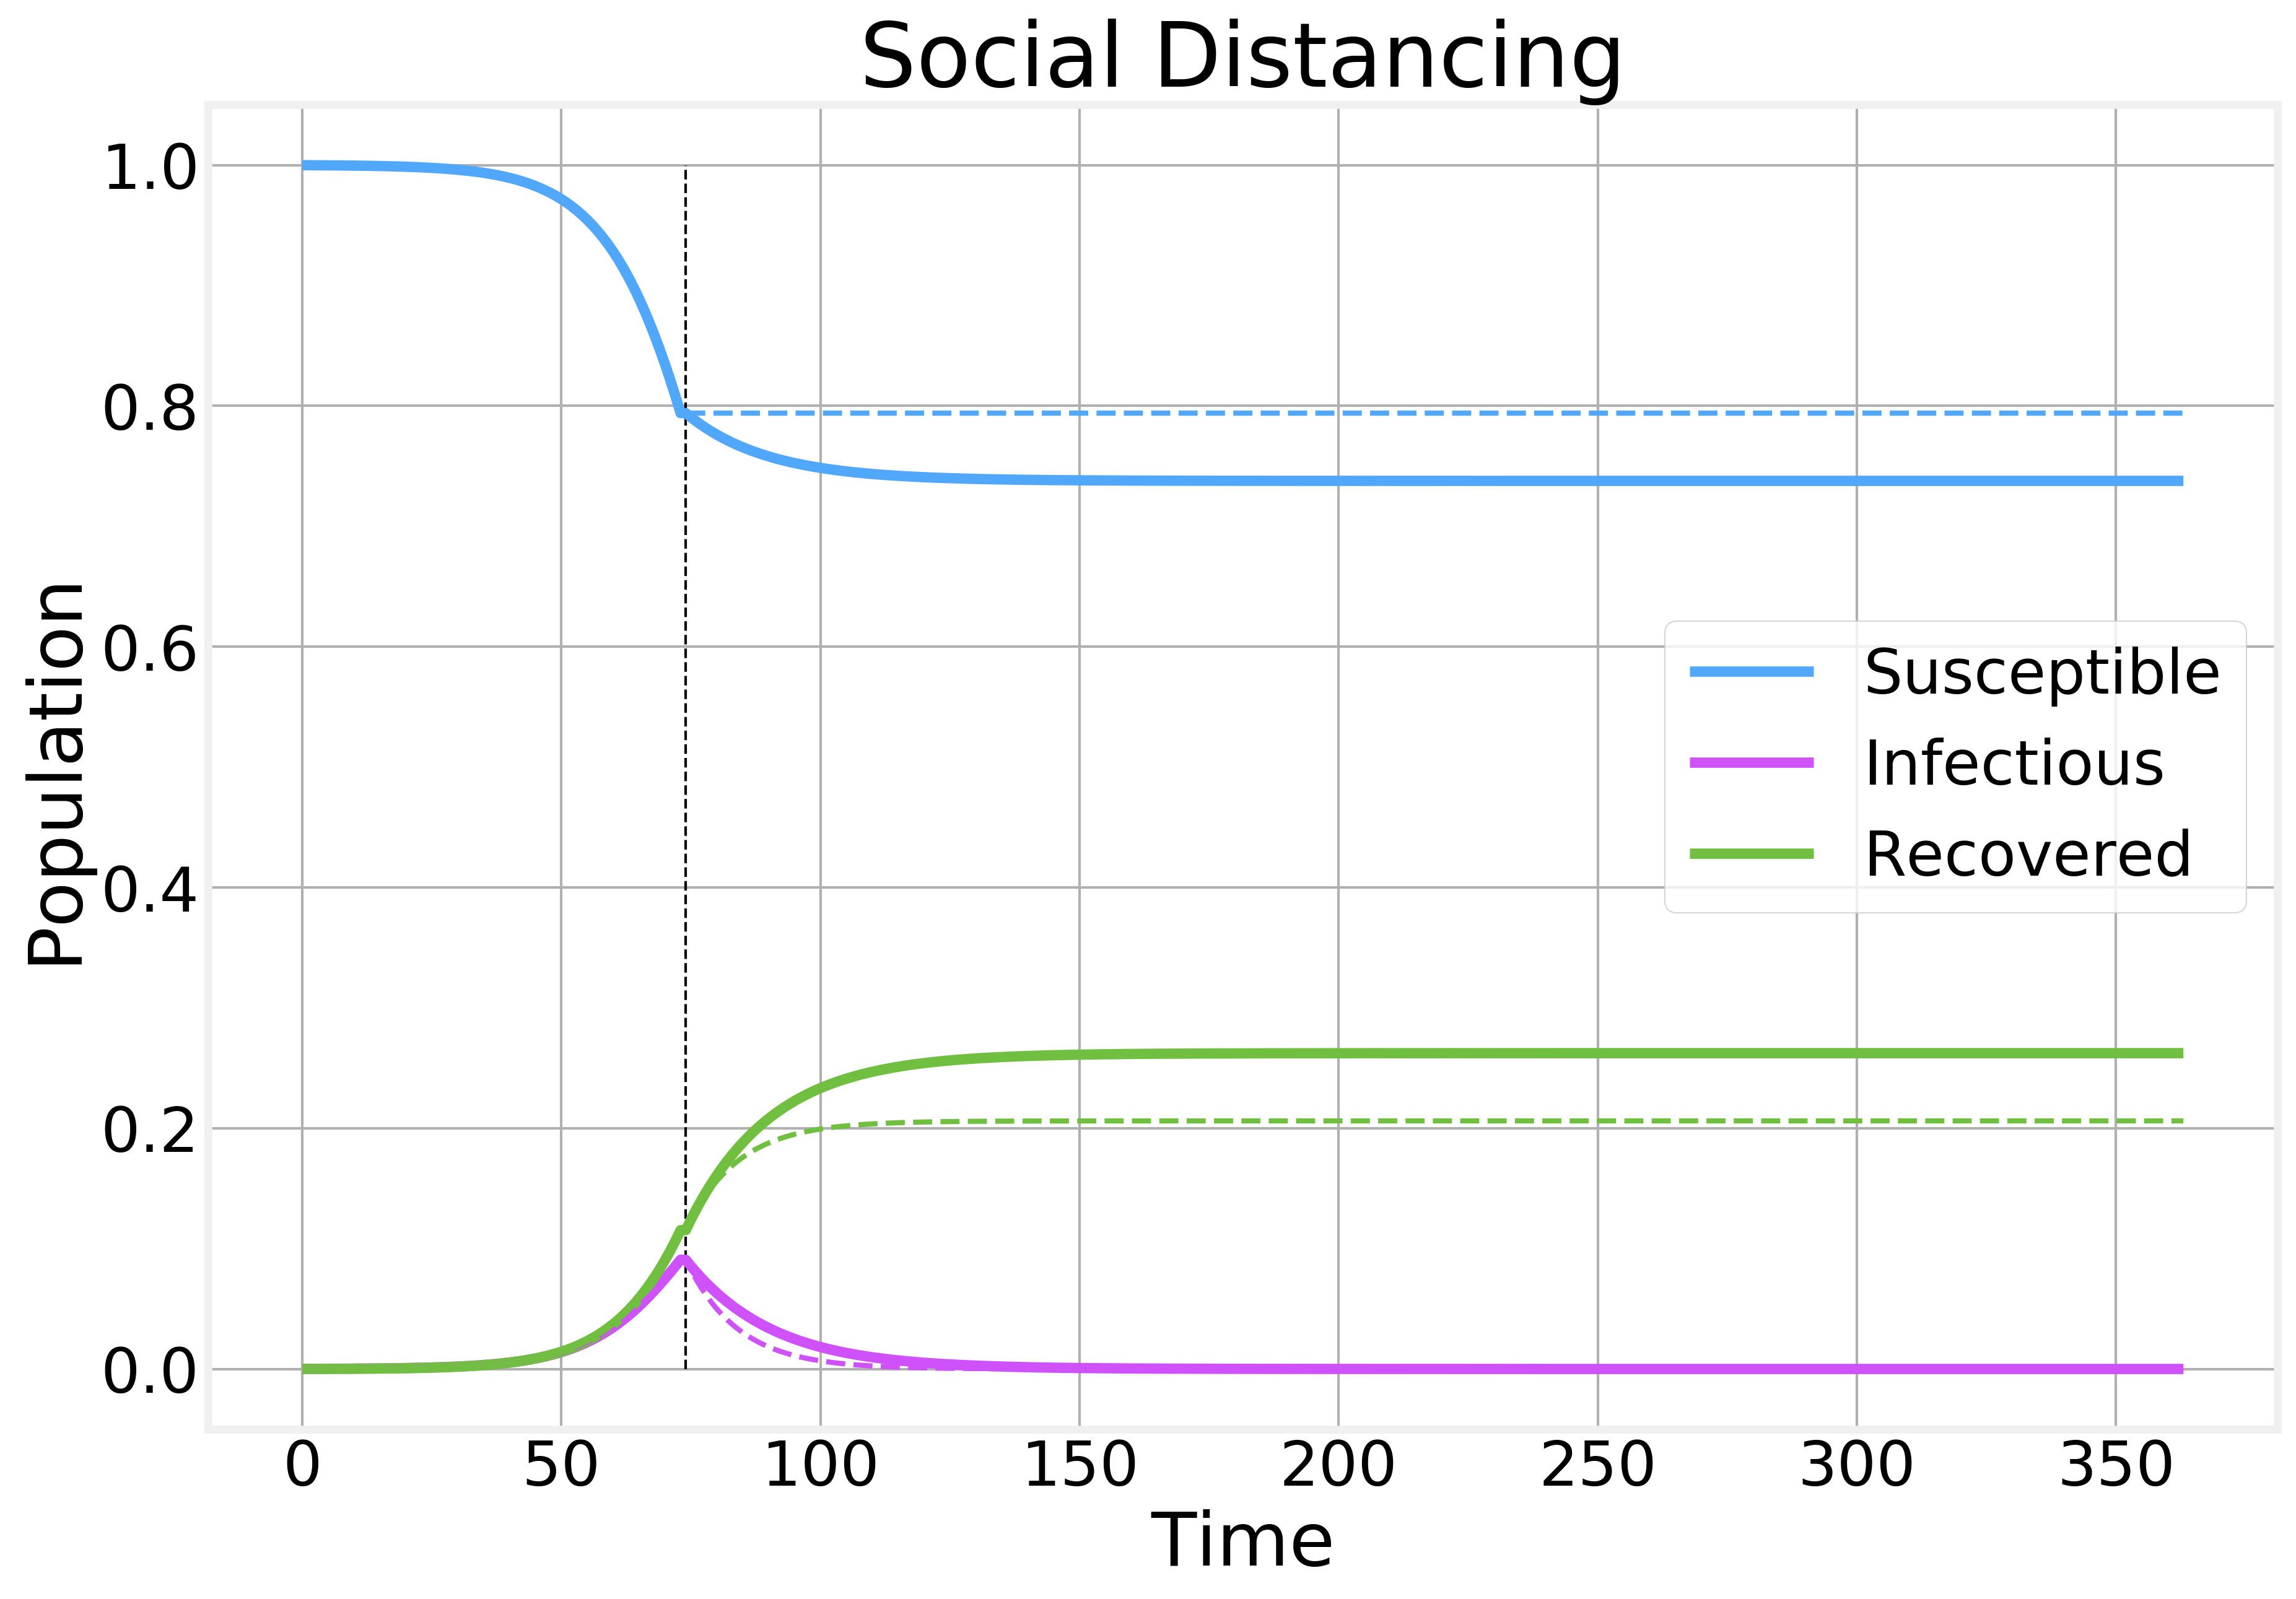

In [74]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = (values2/N).plot()
ax.vlines(x=74, ymax=1, ymin=0, lw=1, linestyle='--')
(values.S/N).plot(ax=ax, lw=2, linestyle='--', c=colors[0])
(values.I/N).plot(ax=ax, lw=2, linestyle='--', c=colors[1])
(values.R/N).plot(ax=ax, lw=2, linestyle='--', c=colors[2])
ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Susceptible', 'Infectious', 'Recovered'])
ax.set_title('Social Distancing')

Naturally, this requries the social distancing procedure to continue for longer and at the end we'll have more people who have been infected.

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>